<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../")
from src import soporte_preprocesamiento as sp
from src import soporte_nulos as sn
from src import soporte_encoding as se
from src import soporte_outliers as so
from src import soporte_ajuste as sa
from src import soporte_1 as s1
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("datos/financial_data.csv", index_col=0).reset_index()

In [3]:
sp.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 11

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
transaction_id,"10,000.00","5,000.50","2,886.90",1.00,"2,500.75","5,000.50","7,500.25","10,000.00"
customer_id,"10,000.00","1,051.27",28.86,"1,001.00","1,026.00","1,052.00","1,076.00","1,100.00"
merchant_id,"10,000.00","2,050.49",28.88,"2,001.00","2,025.00","2,050.00","2,076.00","2,100.00"
amount,"10,000.00","4,958.38","2,899.70",10.61,"2,438.18","4,943.94","7,499.31","9,999.75"
is_fraudulent,"10,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
customer_age,"10,000.00",44.05,15.32,18.00,31.00,44.00,57.00,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 00:00:00,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


None

### Cosas improtantes a que he observado:
- No tienes Outliers

- No hay valores nulos

## Encoding

In [4]:
def detectar_orden (df,categoricas, vr):
    for i in categoricas:
        df_cross_tab = pd.crosstab(df[i], df[vr])

        print (f"Esta es la tabla de contingencia para {i}, con la variable respuesta {vr}")
        print(df_cross_tab)

        chi2, p, dof, expected = chi2_contingency(df_cross_tab)
        if p < 0.05:
            print("La variable categórica TIENE ORDEN")
            print("-----")
        else:
            print("La variable categórica NO TIENE ORDEN")
            print("-----")

In [5]:
lista_col_categ = df.select_dtypes(include="O").columns.tolist()
lista_col_categ.remove("transaction_time")

In [6]:
detectar_orden(df, lista_col_categ, "is_fraudulent")

Esta es la tabla de contingencia para card_type, con la variable respuesta is_fraudulent
is_fraudulent        0     1
card_type                   
American Express  1262  1232
Discover          1304  1329
MasterCard        1140  1243
Visa              1226  1264
La variable categórica NO TIENE ORDEN
-----
Esta es la tabla de contingencia para location, con la variable respuesta is_fraudulent
is_fraudulent    0    1
location               
City-1          80  108
City-10        100   94
City-11         92  107
City-12        102  107
City-13         99  110
City-14        106  112
City-15         96   88
City-16         92   94
City-17        109   96
City-18         89  105
City-19        103   98
City-2          97   88
City-20        102  113
City-21         92   99
City-22        119   94
City-23         95  114
City-24        114  103
City-25        104  103
City-26         83  109
City-27         95   96
City-28         95  112
City-29         94  103
City-3          99   96
City-

In [7]:
print(lista_col_categ)

['card_type', 'location', 'purchase_category', 'transaction_description']


In [8]:
df

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,"5,758.59",2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,"1,901.56",2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,"1,248.86",2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,"7,619.05",2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,"1,890.10",2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,"8,935.28",2023-01-01 02:46:35,1,MasterCard,City-39,Restaurant,36,Purchase at Merchant-2023
9996,9997,1053,2026,30.15,2023-01-01 02:46:36,0,MasterCard,City-32,Retail,42,Purchase at Merchant-2026
9997,9998,1041,2034,"6,333.64",2023-01-01 02:46:37,0,American Express,City-1,Online Shopping,36,Purchase at Merchant-2034
9998,9999,1009,2019,"2,837.13",2023-01-01 02:46:38,1,Visa,City-11,Retail,57,Purchase at Merchant-2019


In [9]:
df.columns

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'transaction_time', 'is_fraudulent', 'card_type', 'location',
       'purchase_category', 'customer_age', 'transaction_description'],
      dtype='object')

In [10]:
diccionario_encoding = { 
                        "onehot": ["purchase_category"]} 
# En caso de que queramos aplicar el método solo a una columna
analisis_encoding = se.Encoding(df, variable_respuesta="is_fraudulent", diccionario_encoding=diccionario_encoding)
df = analisis_encoding.one_hot_encoding()
df = analisis_encoding.target_encoding()
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel
0,1,1082,2027,"5,758.59",2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027,1.00,0.00,0.00,0.00,0.00,0.00
1,2,1015,2053,"1,901.56",2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053,0.00,0.00,1.00,0.00,0.00,0.00
2,3,1004,2035,"1,248.86",2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035,1.00,0.00,0.00,0.00,0.00,0.00
3,4,1095,2037,"7,619.05",2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037,0.00,0.00,0.00,0.00,0.00,1.00
4,5,1036,2083,"1,890.10",2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083,0.00,0.00,0.00,0.00,1.00,0.00


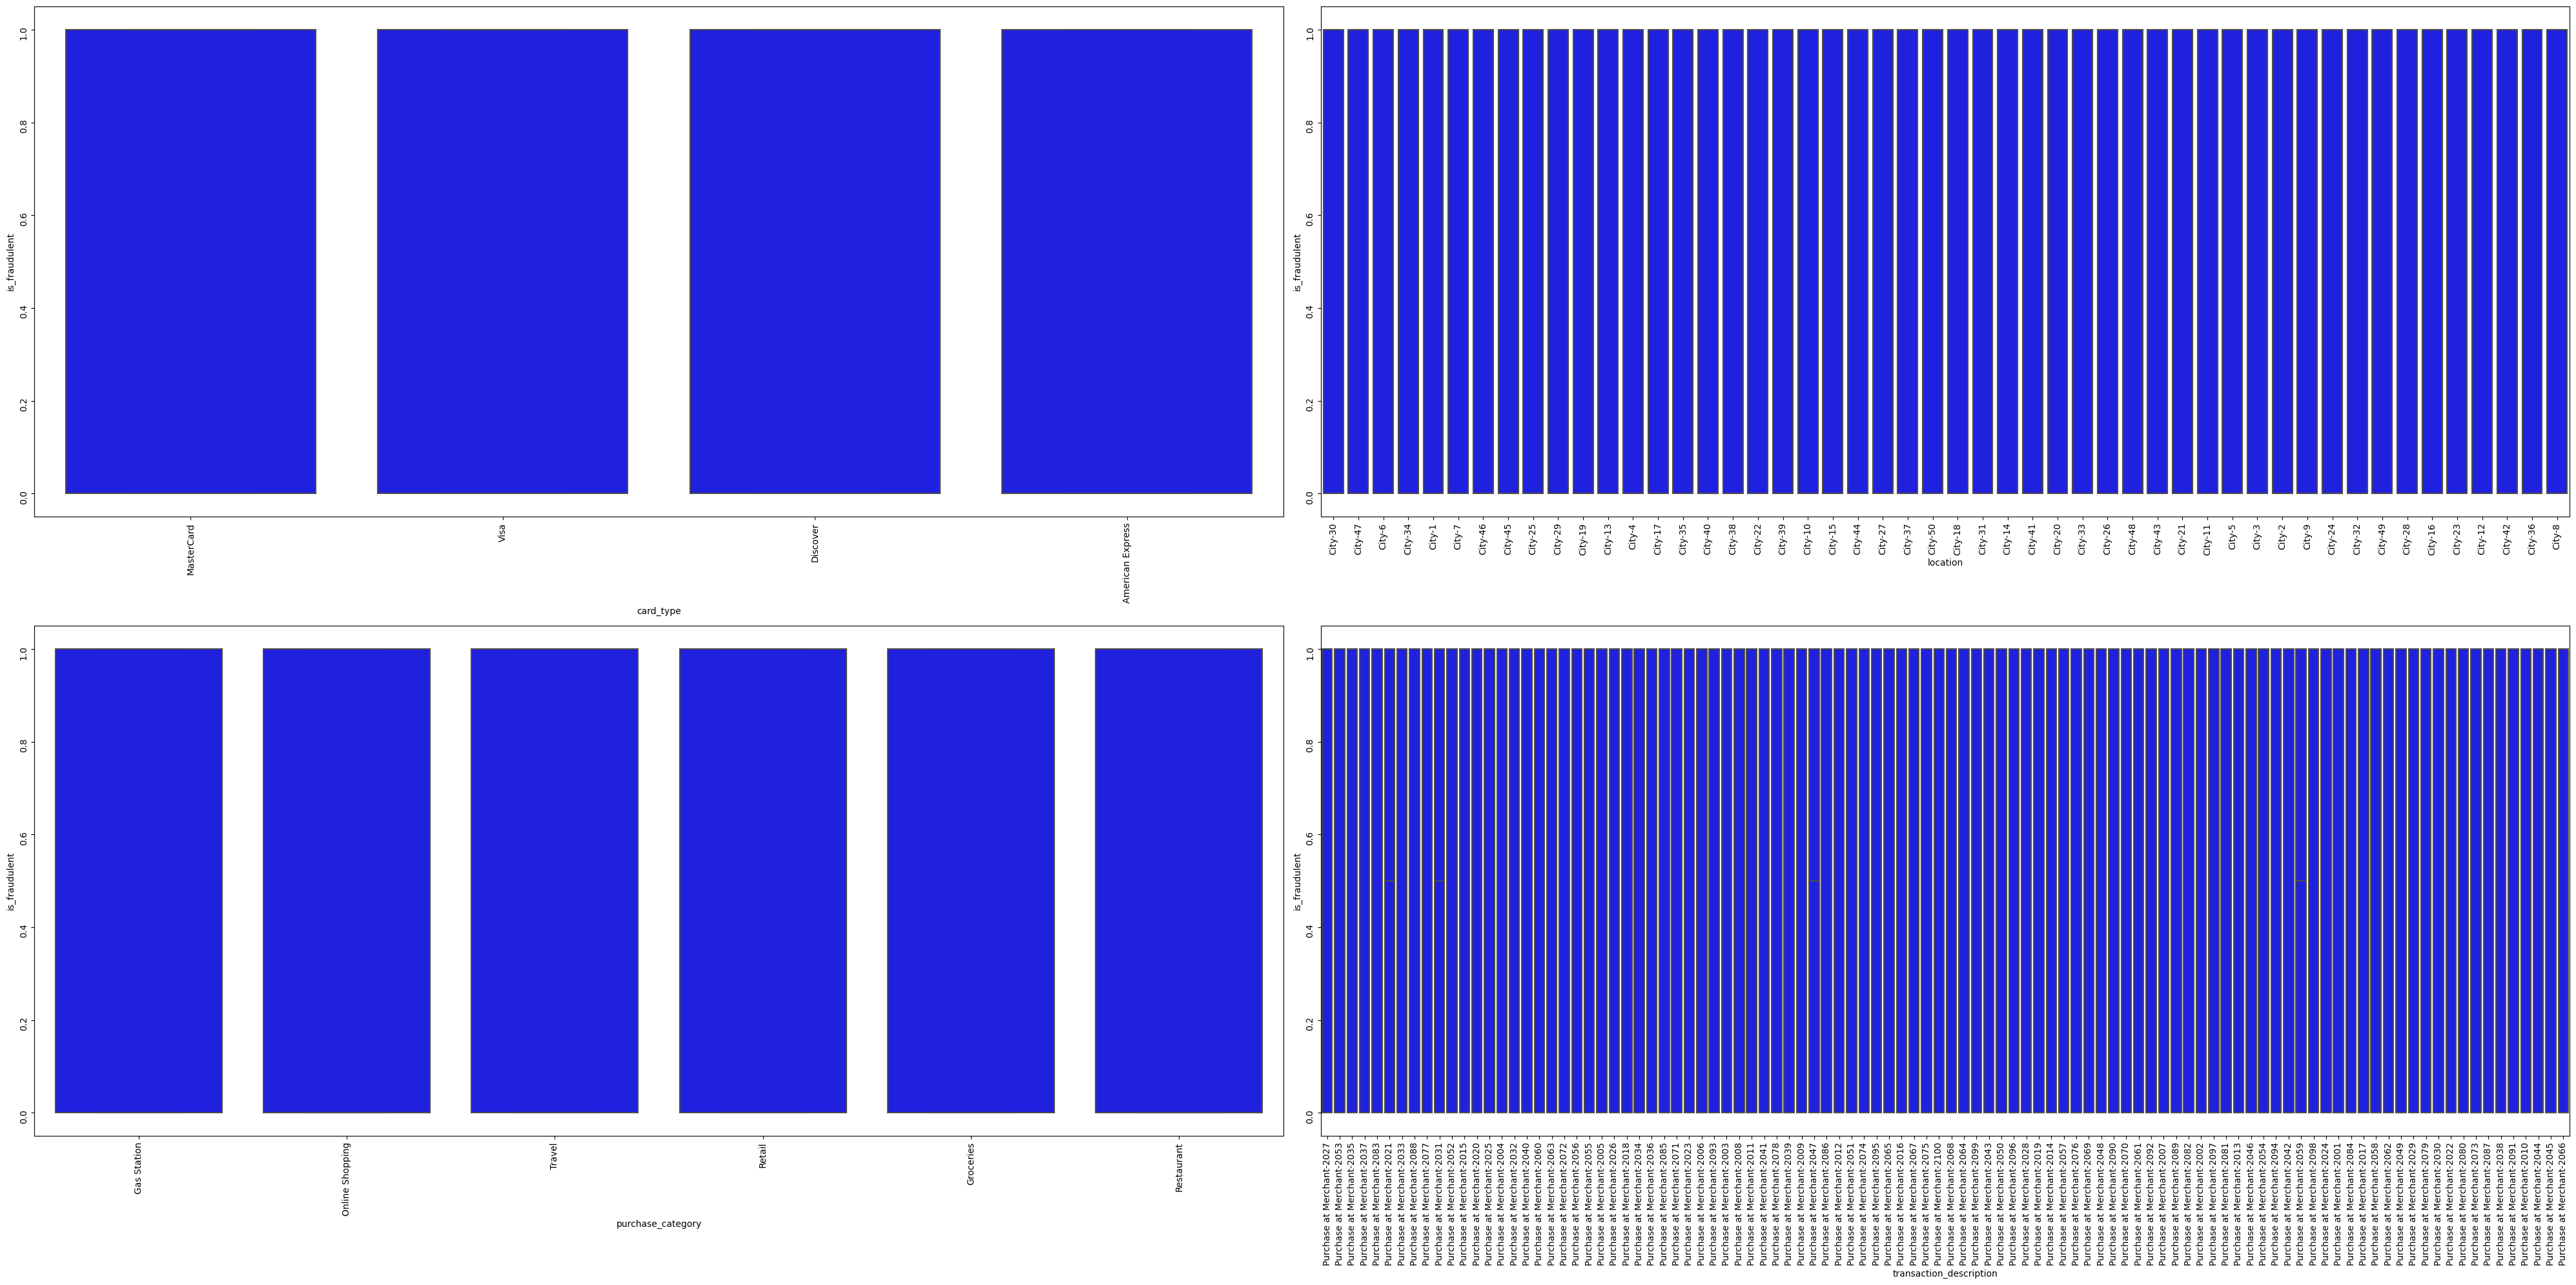

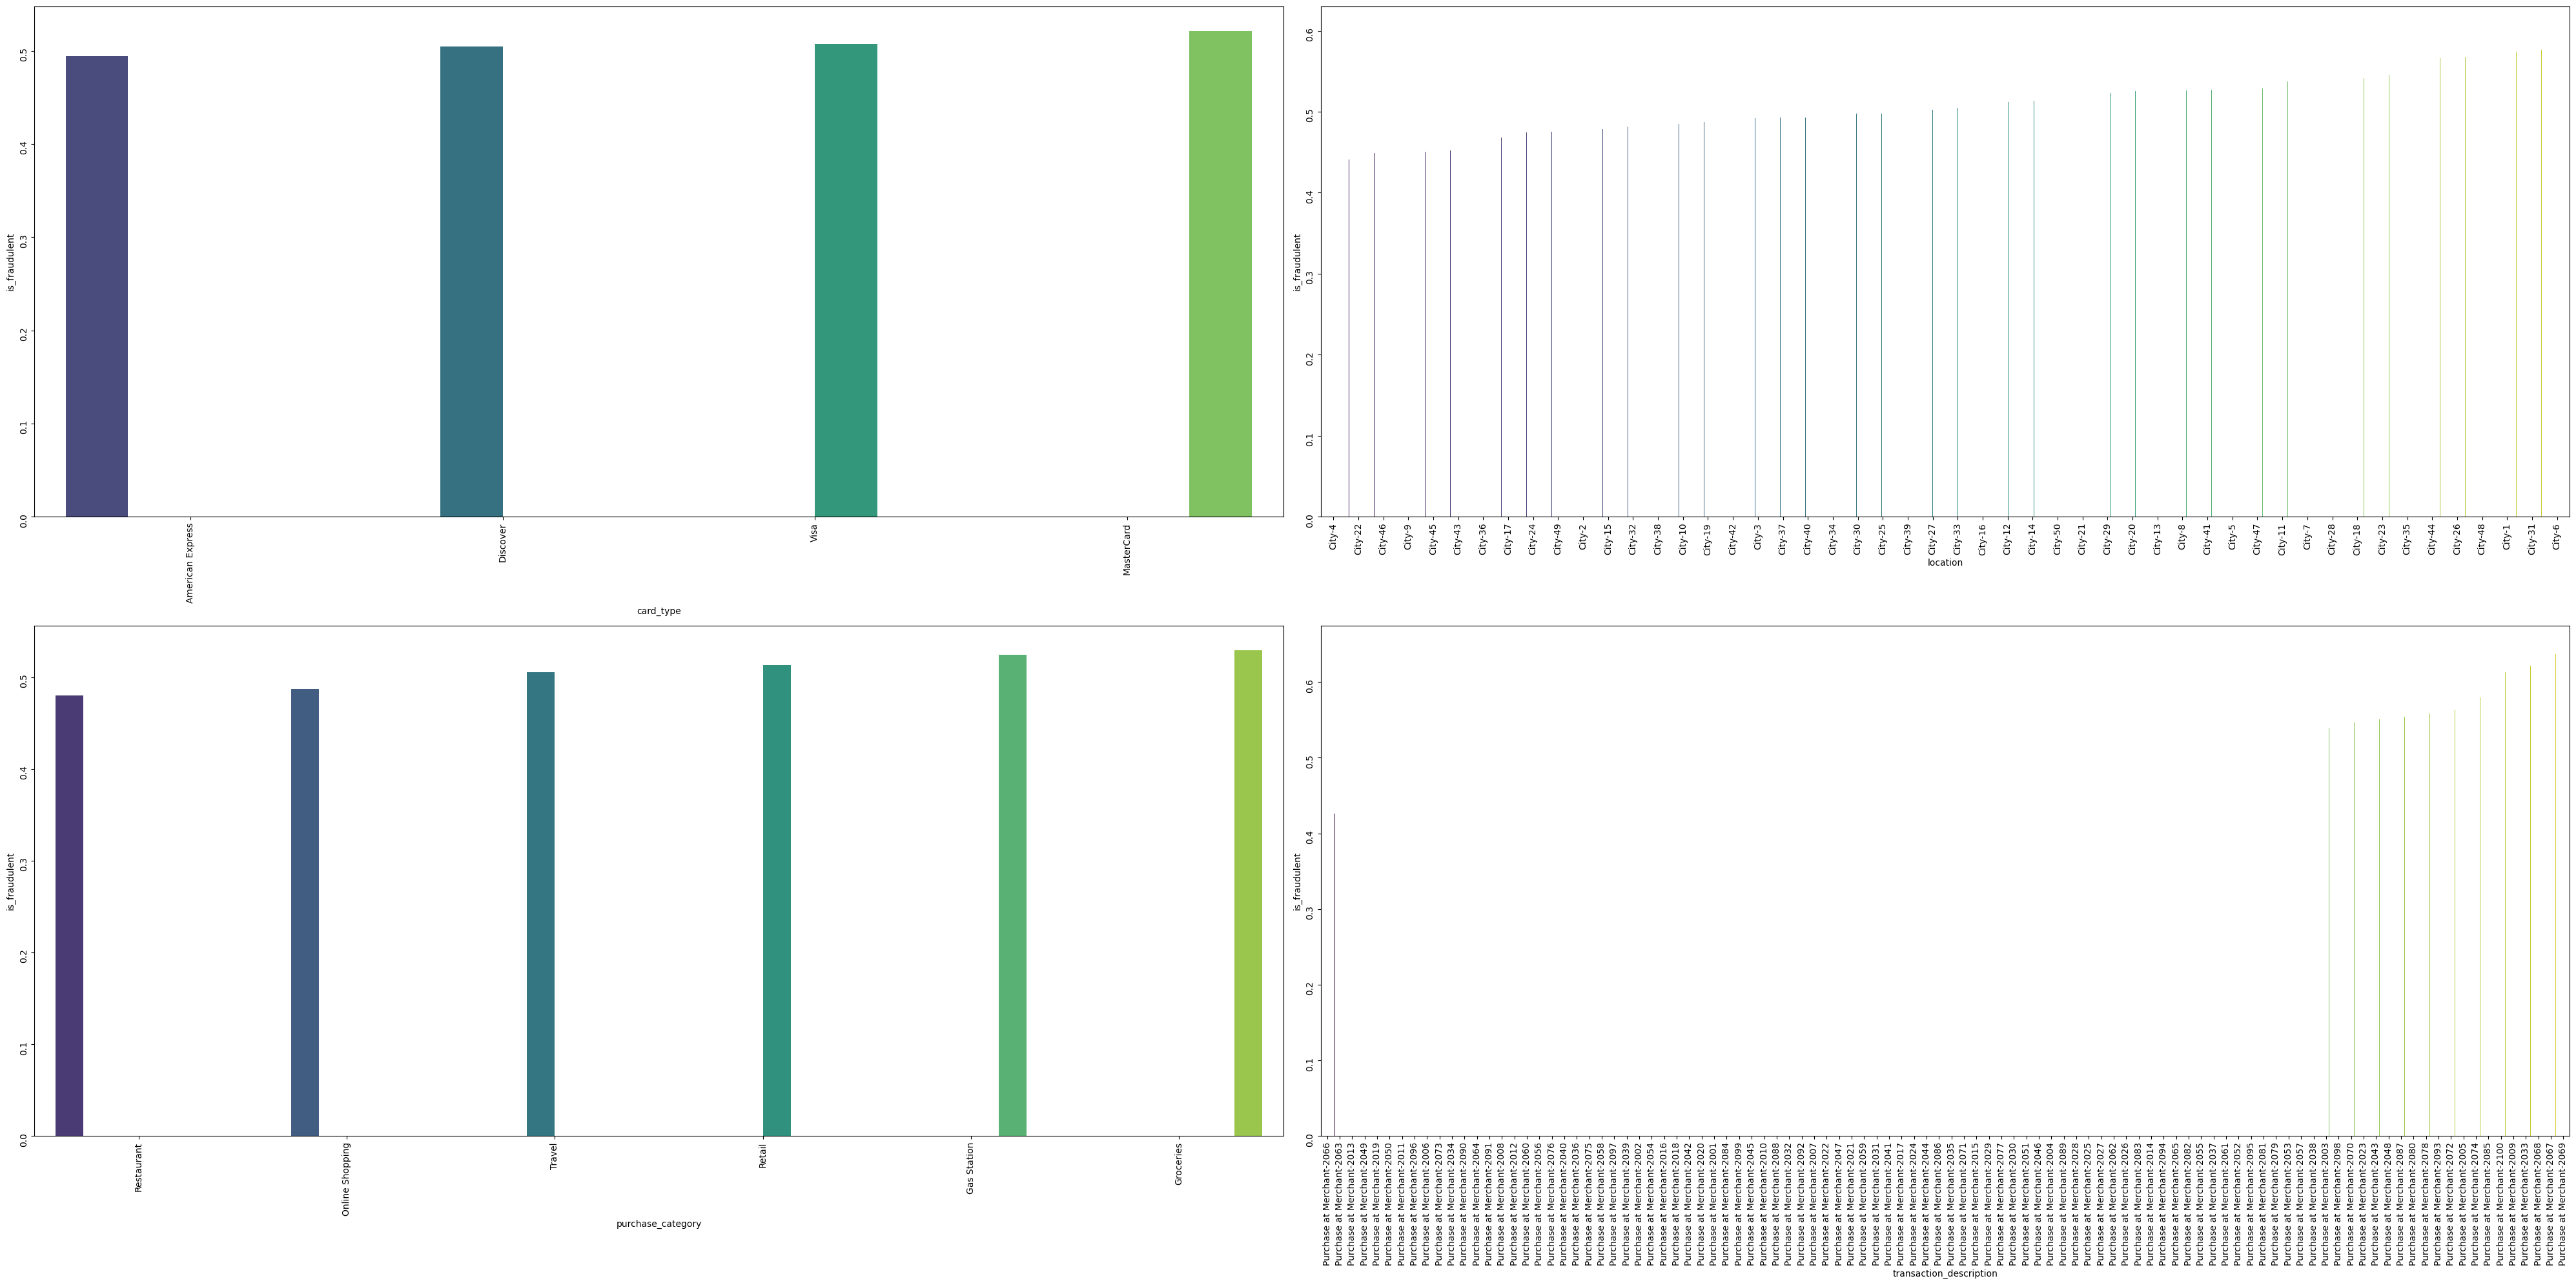

In [11]:
analisis_encoding = se.Analisis_Visual_Encoding(variable_respuesta="is_fraudulent", dataframe=df, lista_variables_categorias= lista_col_categ)

analisis_encoding.crear_boxplot()
analisis_encoding.crear_barplot()

In [12]:
y = df["is_fraudulent"]
X = df.drop('is_fraudulent', axis=1)

In [13]:
df

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel
0,1,1082,2027,"5,758.59",2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027,1.00,0.00,0.00,0.00,0.00,0.00
1,2,1015,2053,"1,901.56",2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053,0.00,0.00,1.00,0.00,0.00,0.00
2,3,1004,2035,"1,248.86",2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035,1.00,0.00,0.00,0.00,0.00,0.00
3,4,1095,2037,"7,619.05",2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037,0.00,0.00,0.00,0.00,0.00,1.00
4,5,1036,2083,"1,890.10",2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,"8,935.28",2023-01-01 02:46:35,1,MasterCard,City-39,Restaurant,36,Purchase at Merchant-2023,0.00,0.00,0.00,1.00,0.00,0.00
9996,9997,1053,2026,30.15,2023-01-01 02:46:36,0,MasterCard,City-32,Retail,42,Purchase at Merchant-2026,0.00,0.00,0.00,0.00,1.00,0.00
9997,9998,1041,2034,"6,333.64",2023-01-01 02:46:37,0,American Express,City-1,Online Shopping,36,Purchase at Merchant-2034,0.00,0.00,1.00,0.00,0.00,0.00
9998,9999,1009,2019,"2,837.13",2023-01-01 02:46:38,1,Visa,City-11,Retail,57,Purchase at Merchant-2019,0.00,0.00,0.00,0.00,1.00,0.00


In [14]:
tar_encoder = TargetEncoder(lista_col_categ)
df = tar_encoder.fit_transform(df, df["is_fraudulent"])
df

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel
0,1,1082,2027,"5,758.59",0.44,0,0.52,0.50,0.52,43,0.52,1.00,0.00,0.00,0.00,0.00,0.00
1,2,1015,2053,"1,901.56",0.57,1,0.51,0.53,0.49,61,0.54,0.00,0.00,1.00,0.00,0.00,0.00
2,3,1004,2035,"1,248.86",0.57,1,0.52,0.60,0.52,57,0.51,1.00,0.00,0.00,0.00,0.00,0.00
3,4,1095,2037,"7,619.05",0.57,1,0.50,0.60,0.51,59,0.53,0.00,0.00,0.00,0.00,0.00,1.00
4,5,1036,2083,"1,890.10",0.57,1,0.52,0.50,0.51,36,0.52,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,"8,935.28",0.57,1,0.52,0.50,0.48,36,0.55,0.00,0.00,0.00,1.00,0.00,0.00
9996,9997,1053,2026,30.15,0.44,0,0.52,0.48,0.51,42,0.52,0.00,0.00,0.00,0.00,1.00,0.00
9997,9998,1041,2034,"6,333.64",0.44,0,0.49,0.57,0.49,36,0.45,0.00,0.00,1.00,0.00,0.00,0.00
9998,9999,1009,2019,"2,837.13",0.57,1,0.51,0.54,0.51,57,0.44,0.00,0.00,0.00,0.00,1.00,0.00


## Outliers

In [15]:
GestorOutliersUnivariados = so.GestionOutliersUnivariados(df)
GestorOutliersMultivariados = so.GestionOutliersMultivariados(df)

#### Tras ver las graficas obtenidos podemos decir que no hay outliers univariados, ya que si los hubiese se representarian más alla de sus bigotes

In [16]:
outliers_iqr = GestorOutliersUnivariados.detectar_outliers_iqr()

La cantidad de outliers que tenemos para la columna CARD_TYPE es 4877
La cantidad de outliers que tenemos para la columna TRANSACTION_DESCRIPTION es 295
La cantidad de outliers que tenemos para la columna PURCHASE_CATEGORY_GAS STATION es 1666
La cantidad de outliers que tenemos para la columna PURCHASE_CATEGORY_GROCERIES es 1692
La cantidad de outliers que tenemos para la columna PURCHASE_CATEGORY_ONLINE SHOPPING es 1651
La cantidad de outliers que tenemos para la columna PURCHASE_CATEGORY_RESTAURANT es 1636
La cantidad de outliers que tenemos para la columna PURCHASE_CATEGORY_RETAIL es 1661
La cantidad de outliers que tenemos para la columna PURCHASE_CATEGORY_TRAVEL es 1694


> ¡OJO! estos outliers vienen marcados por el encoding

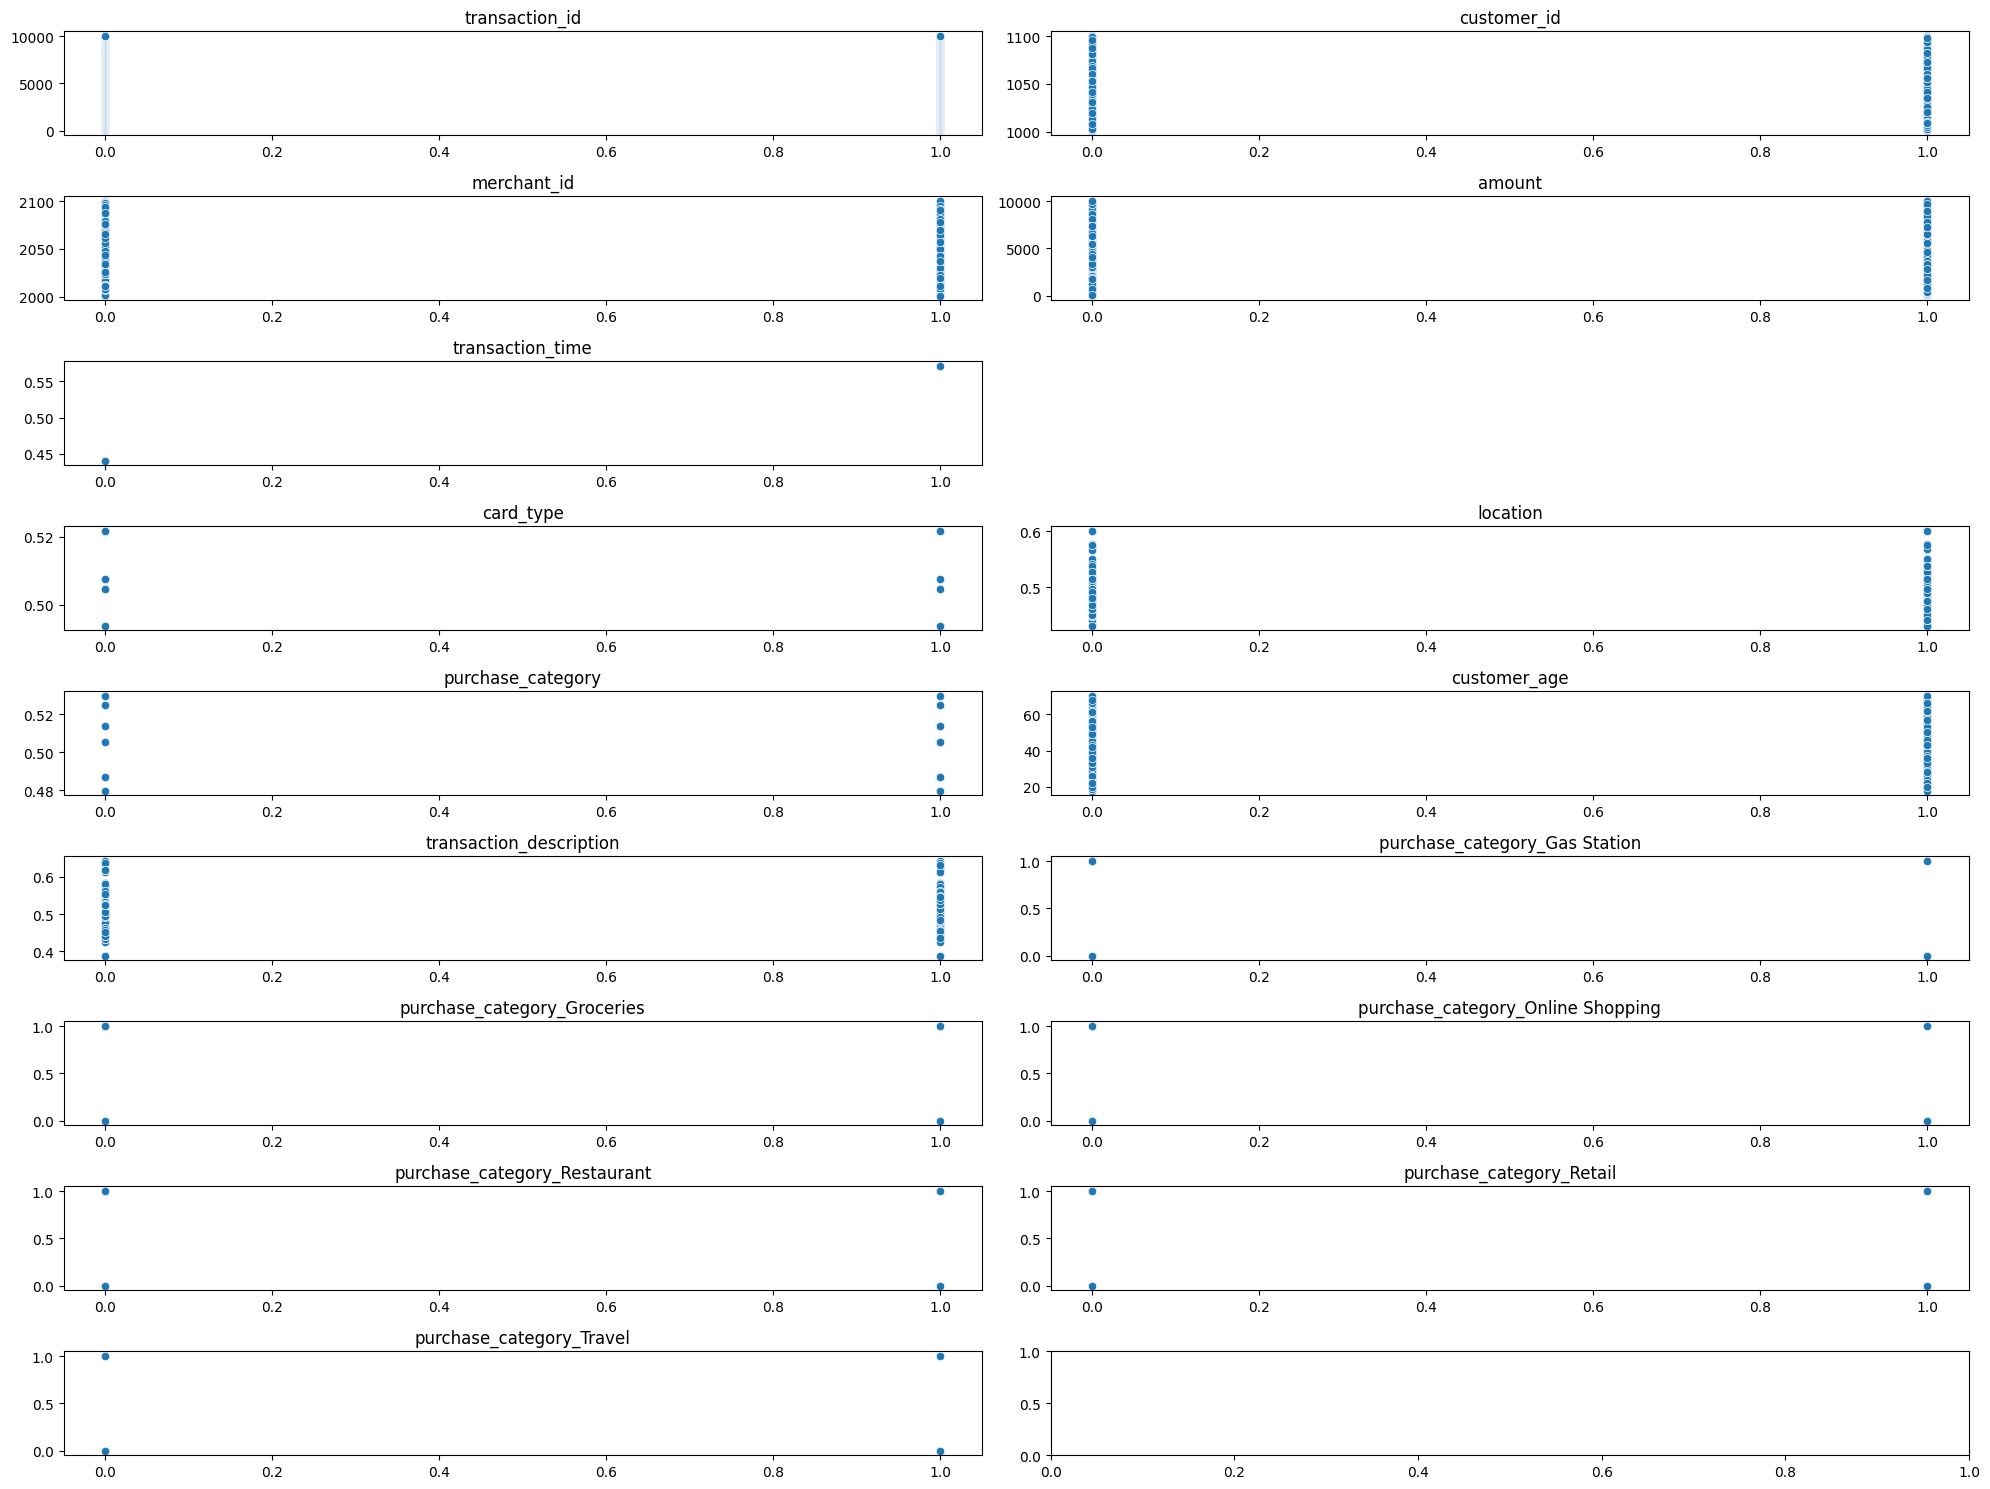

In [17]:
GestorOutliersMultivariados.visualizar_outliers_bivariados("is_fraudulent")

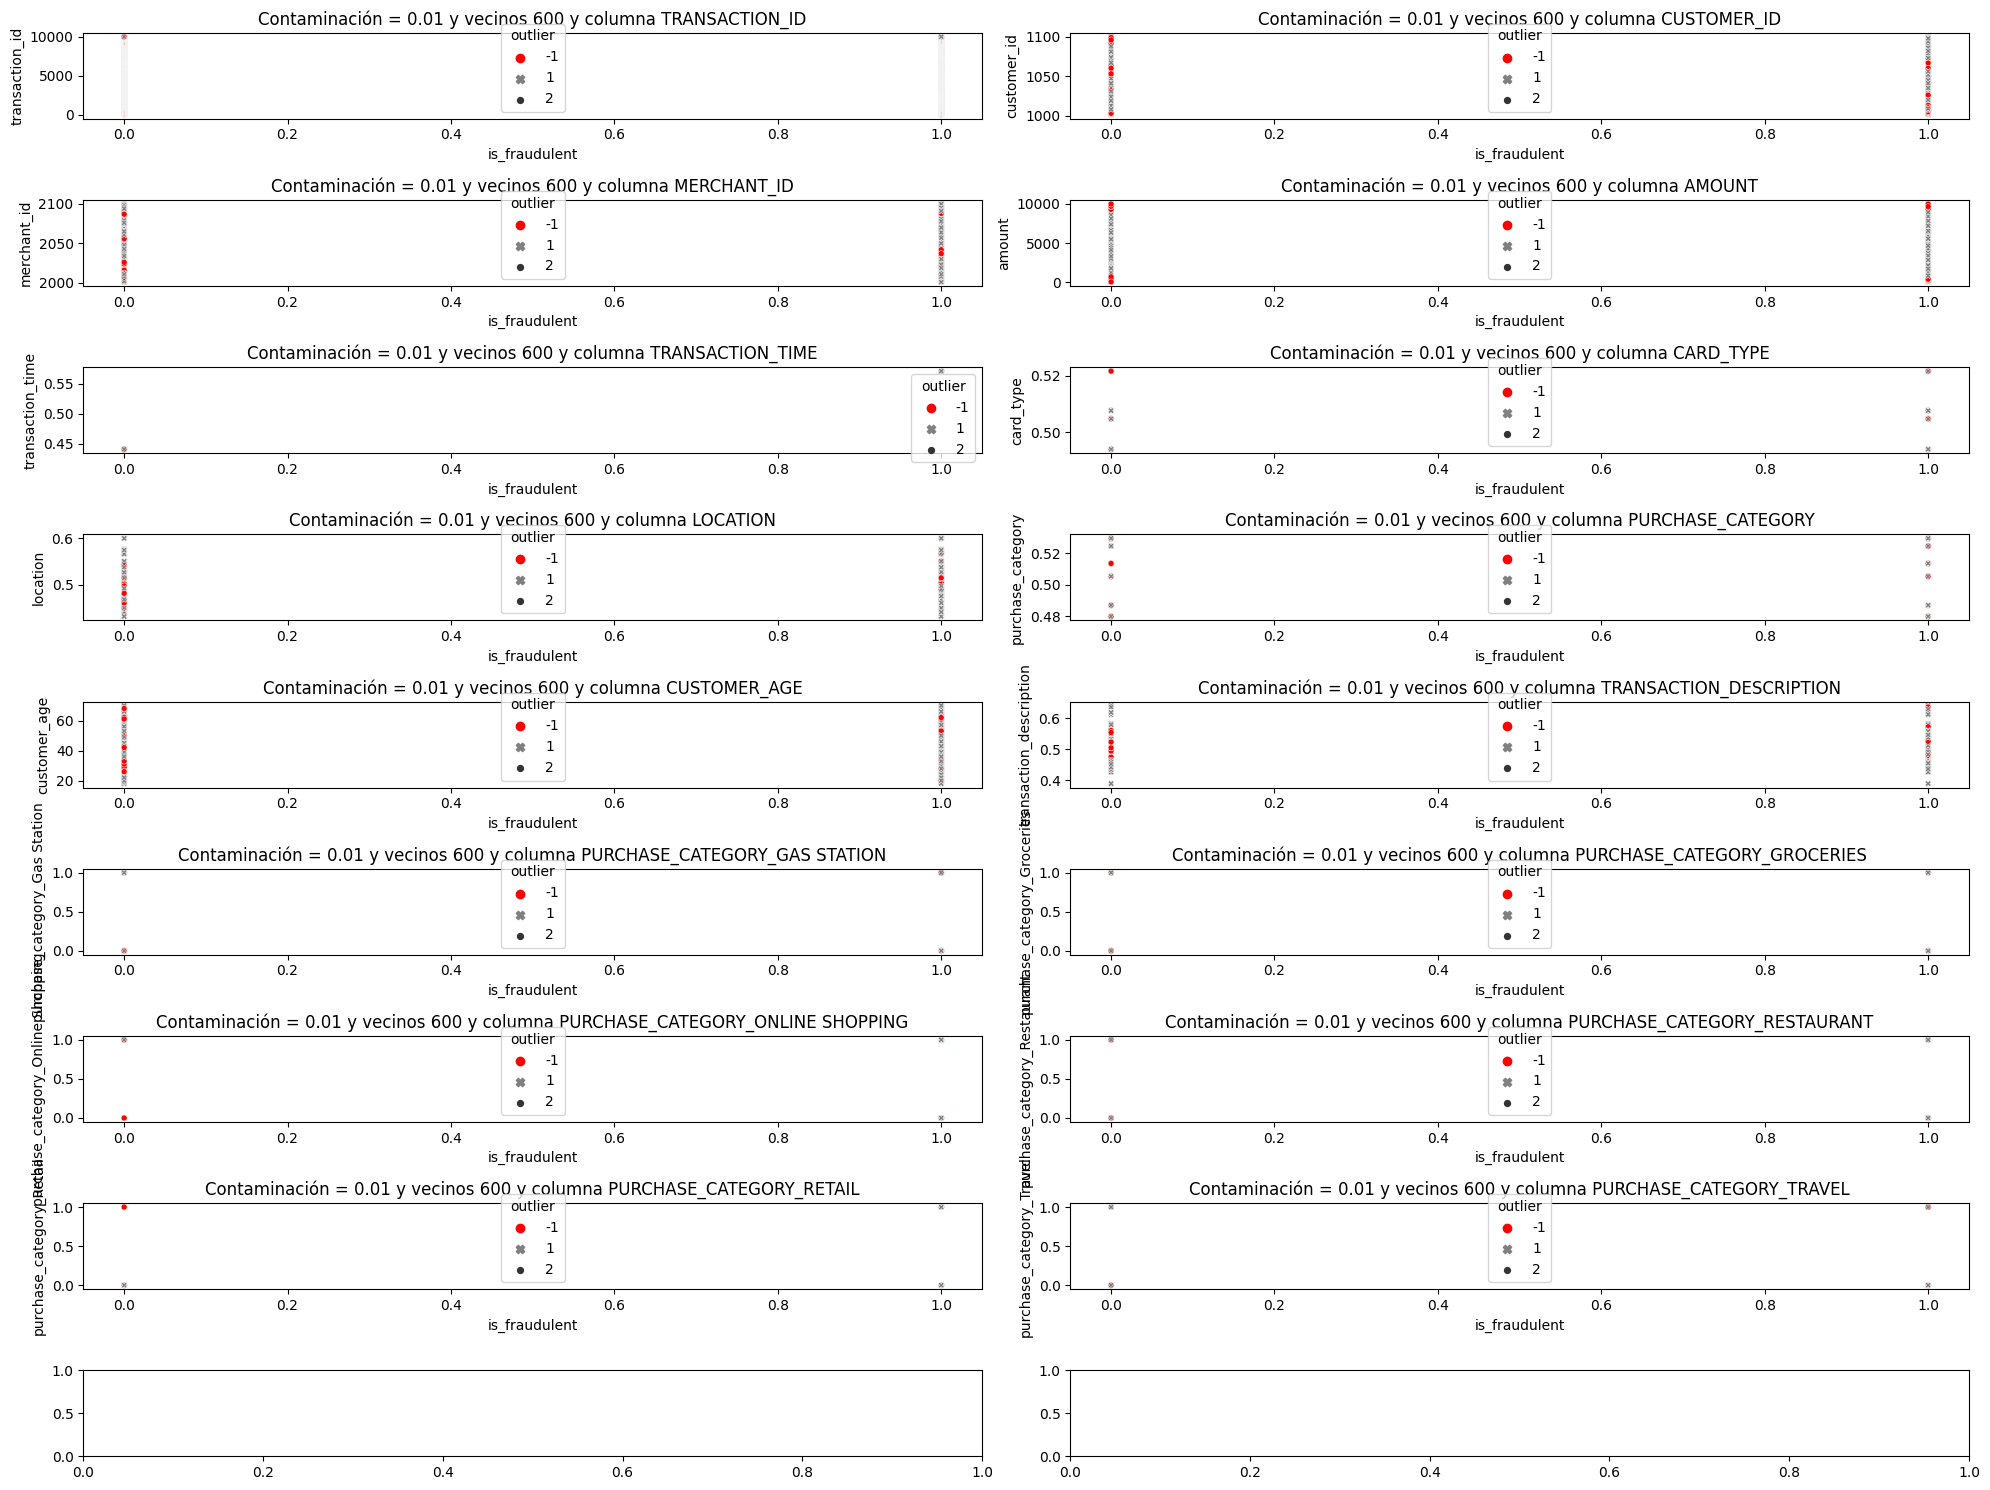

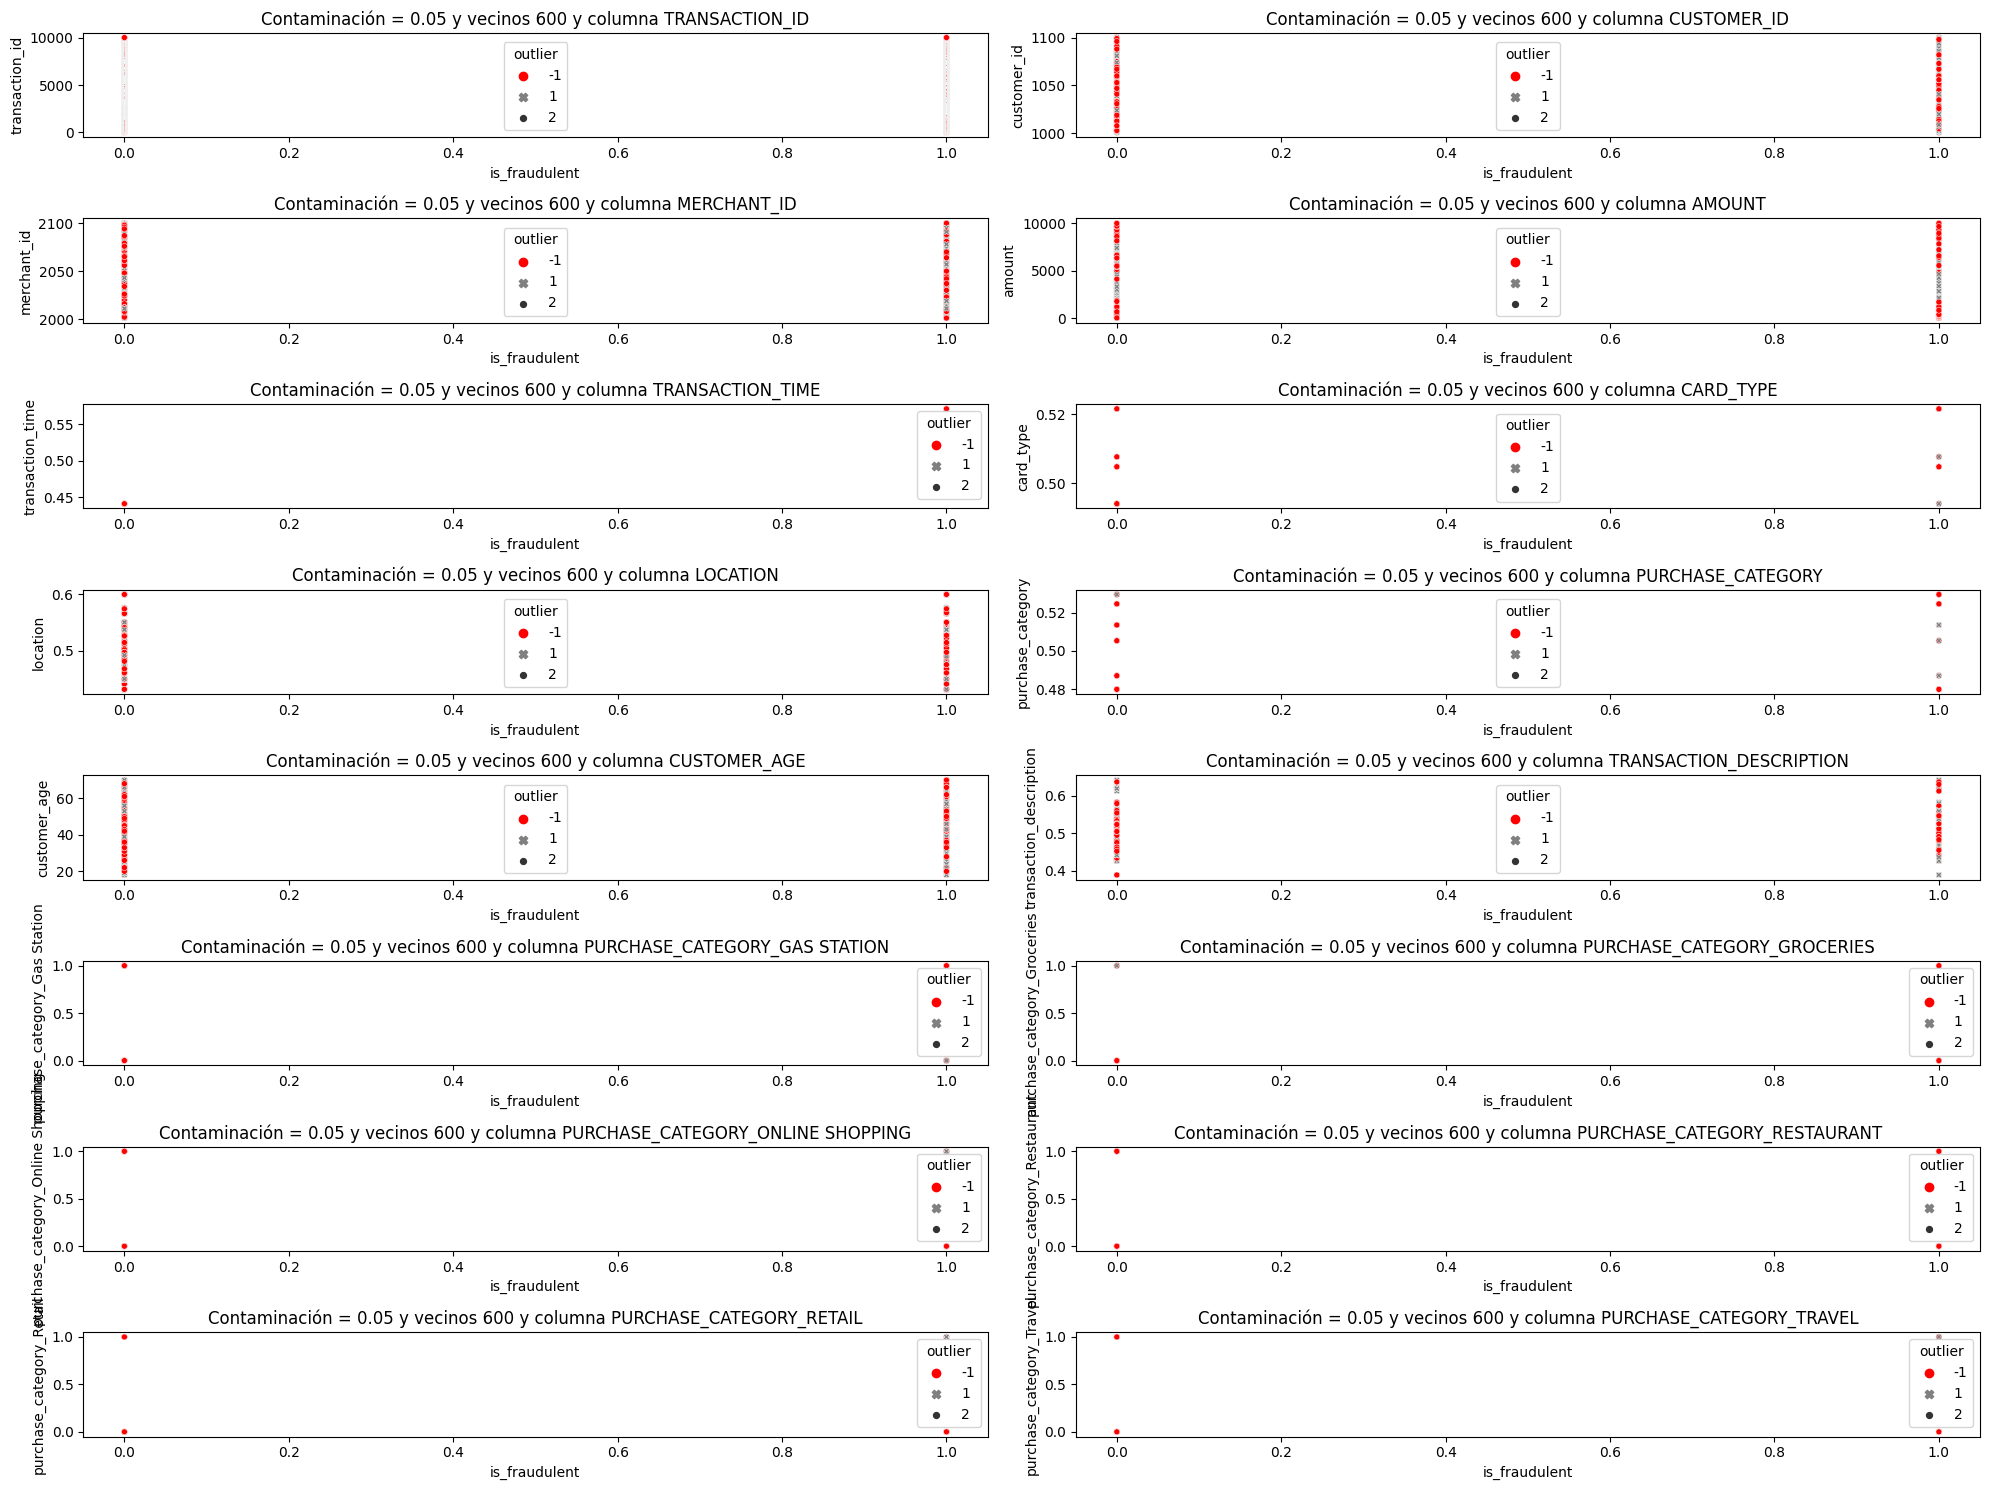

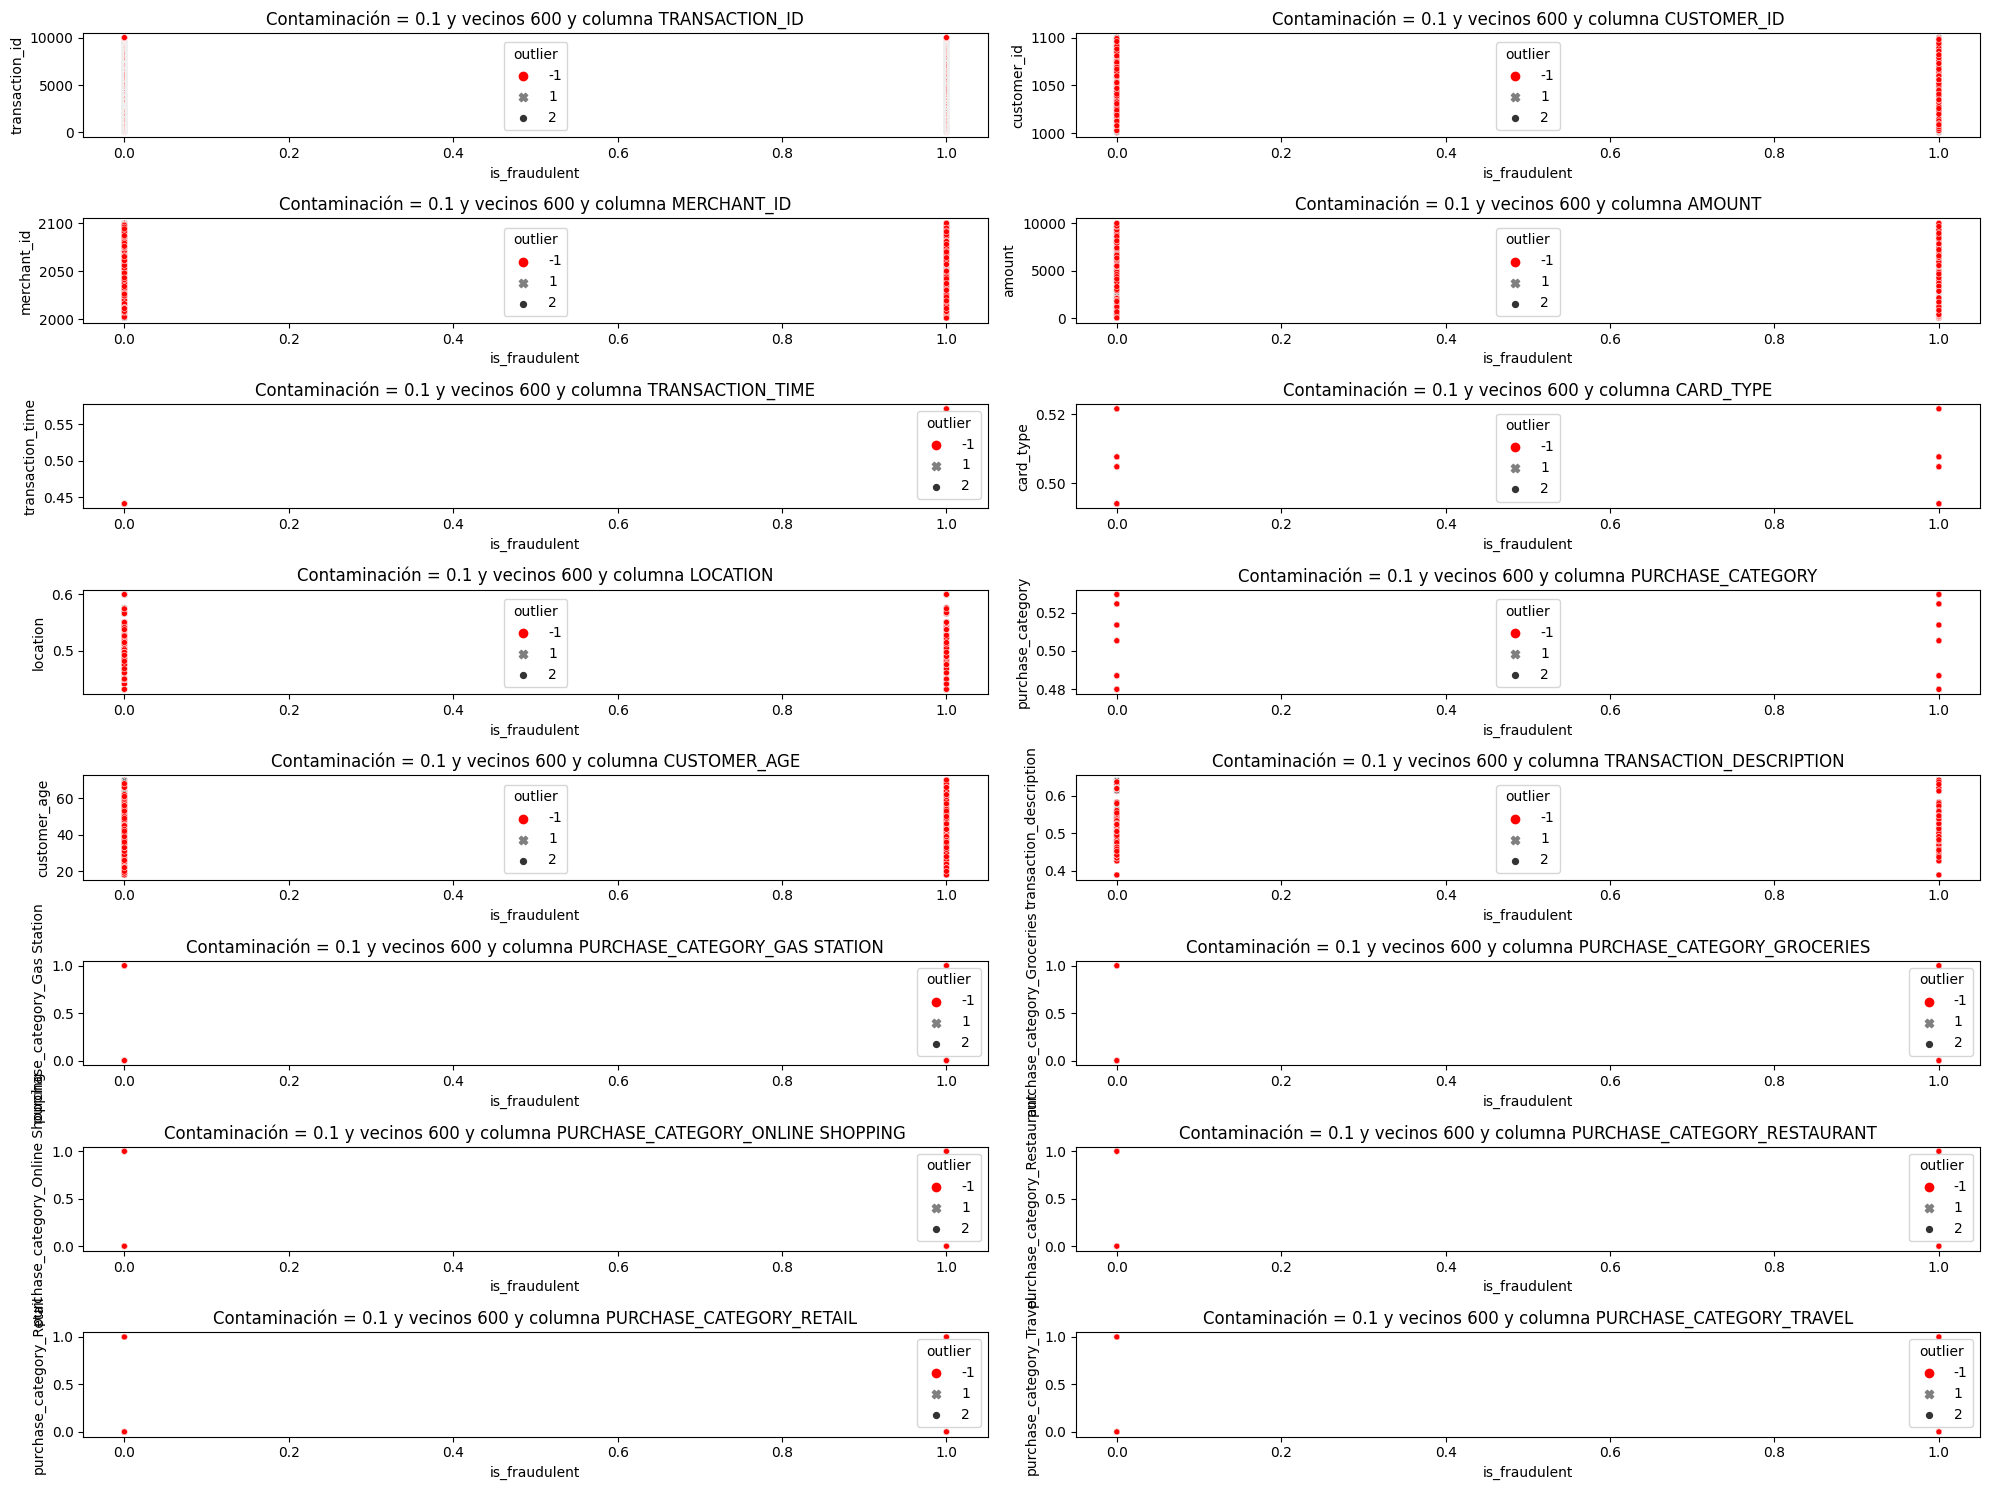

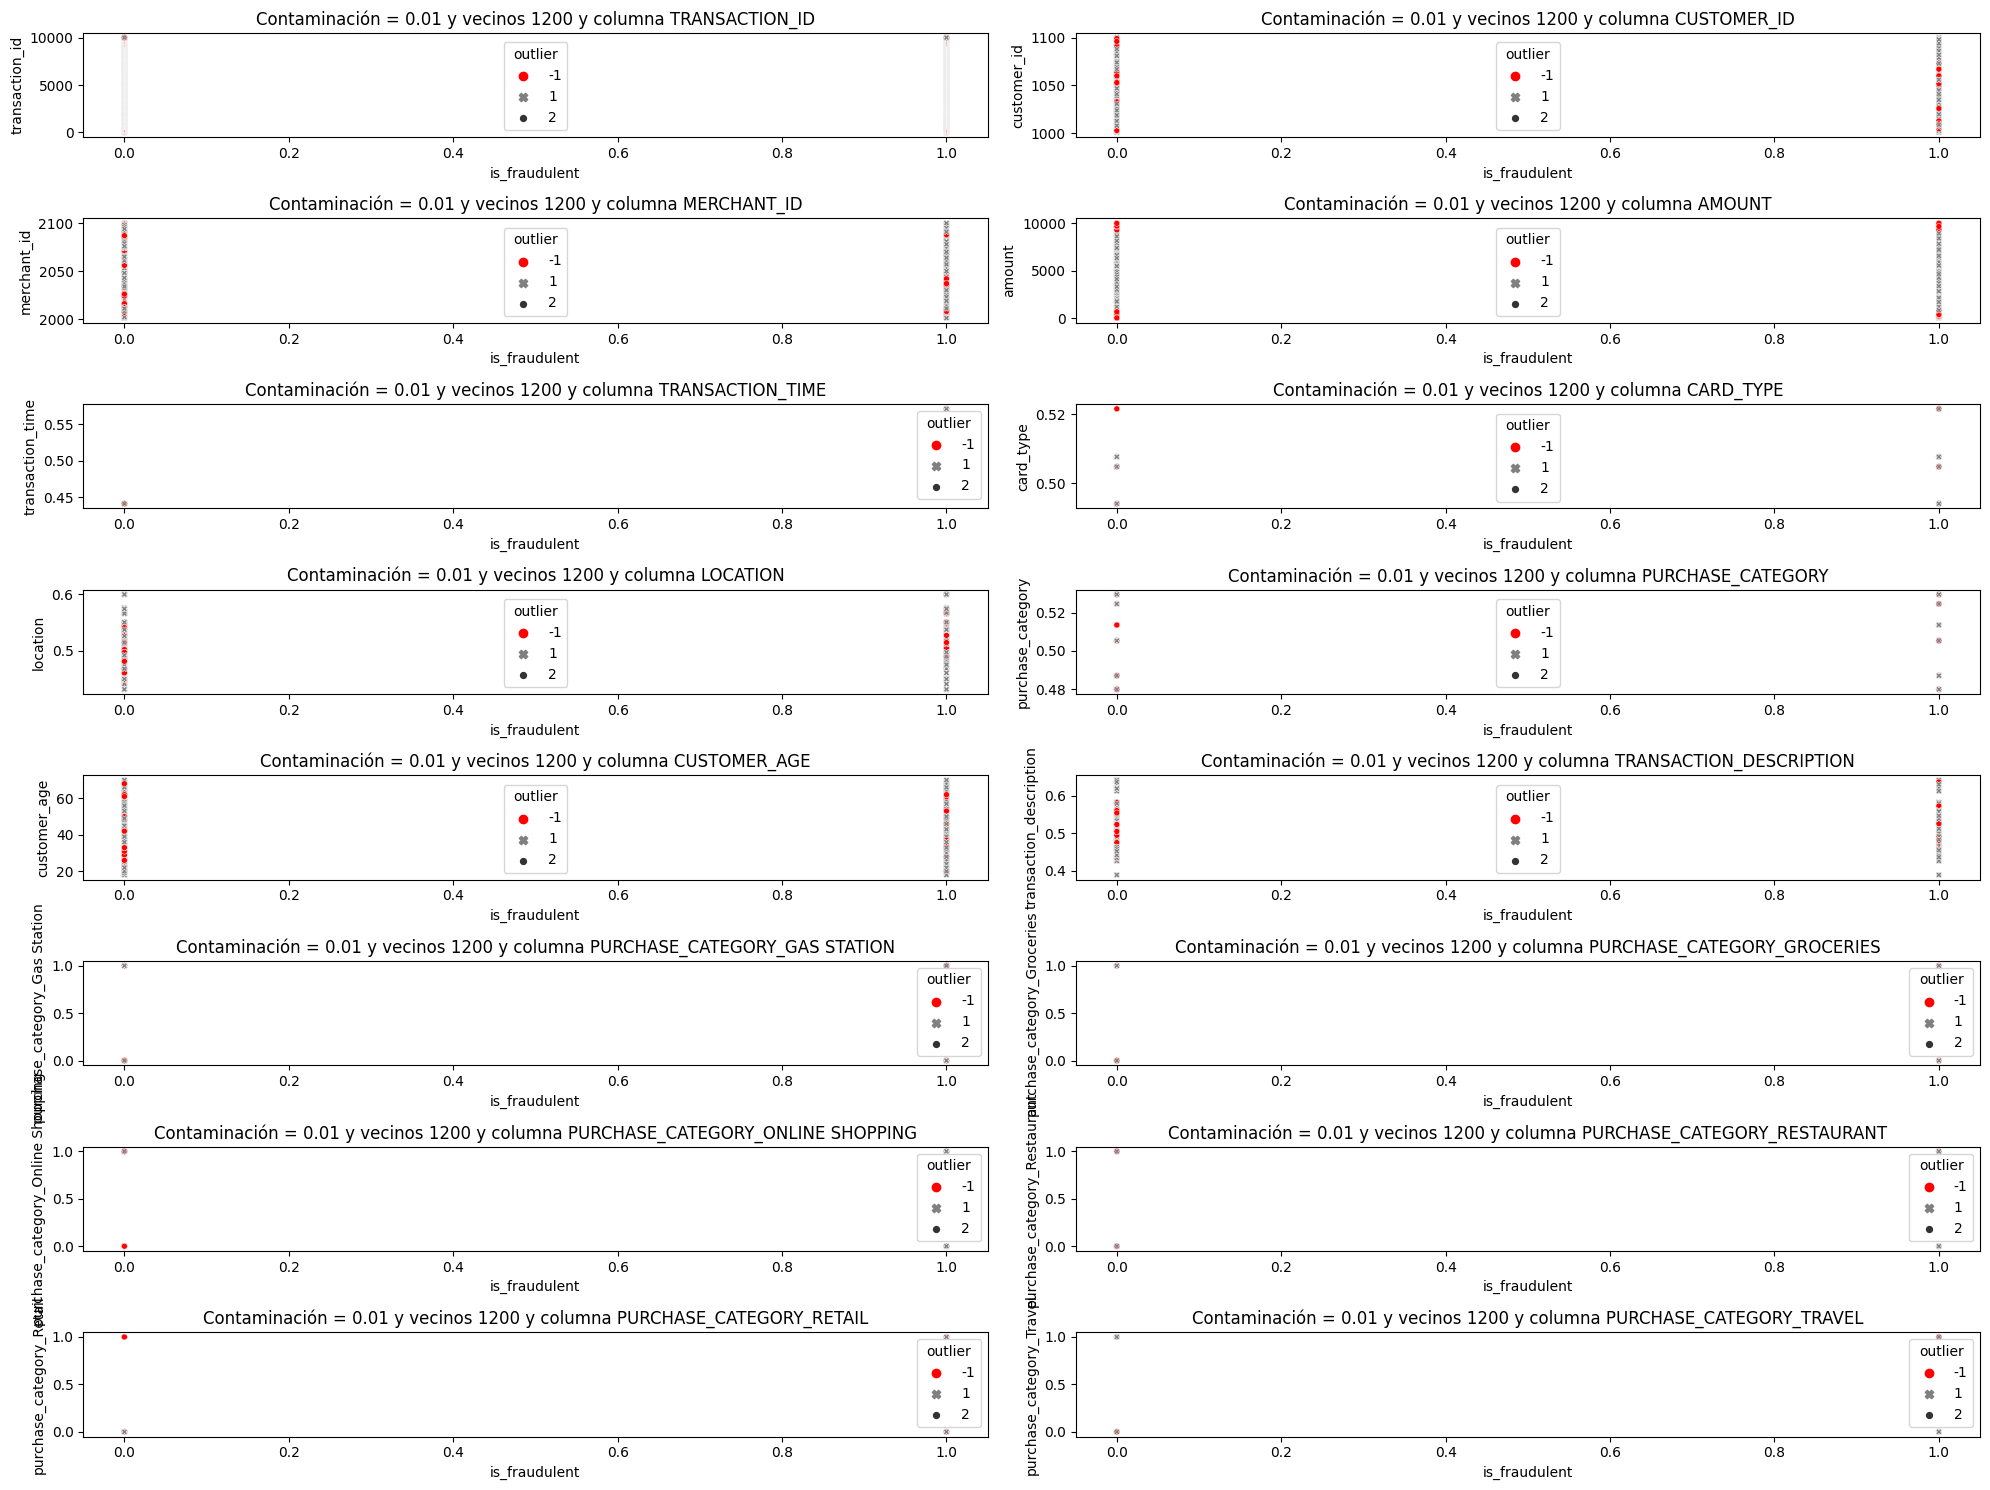

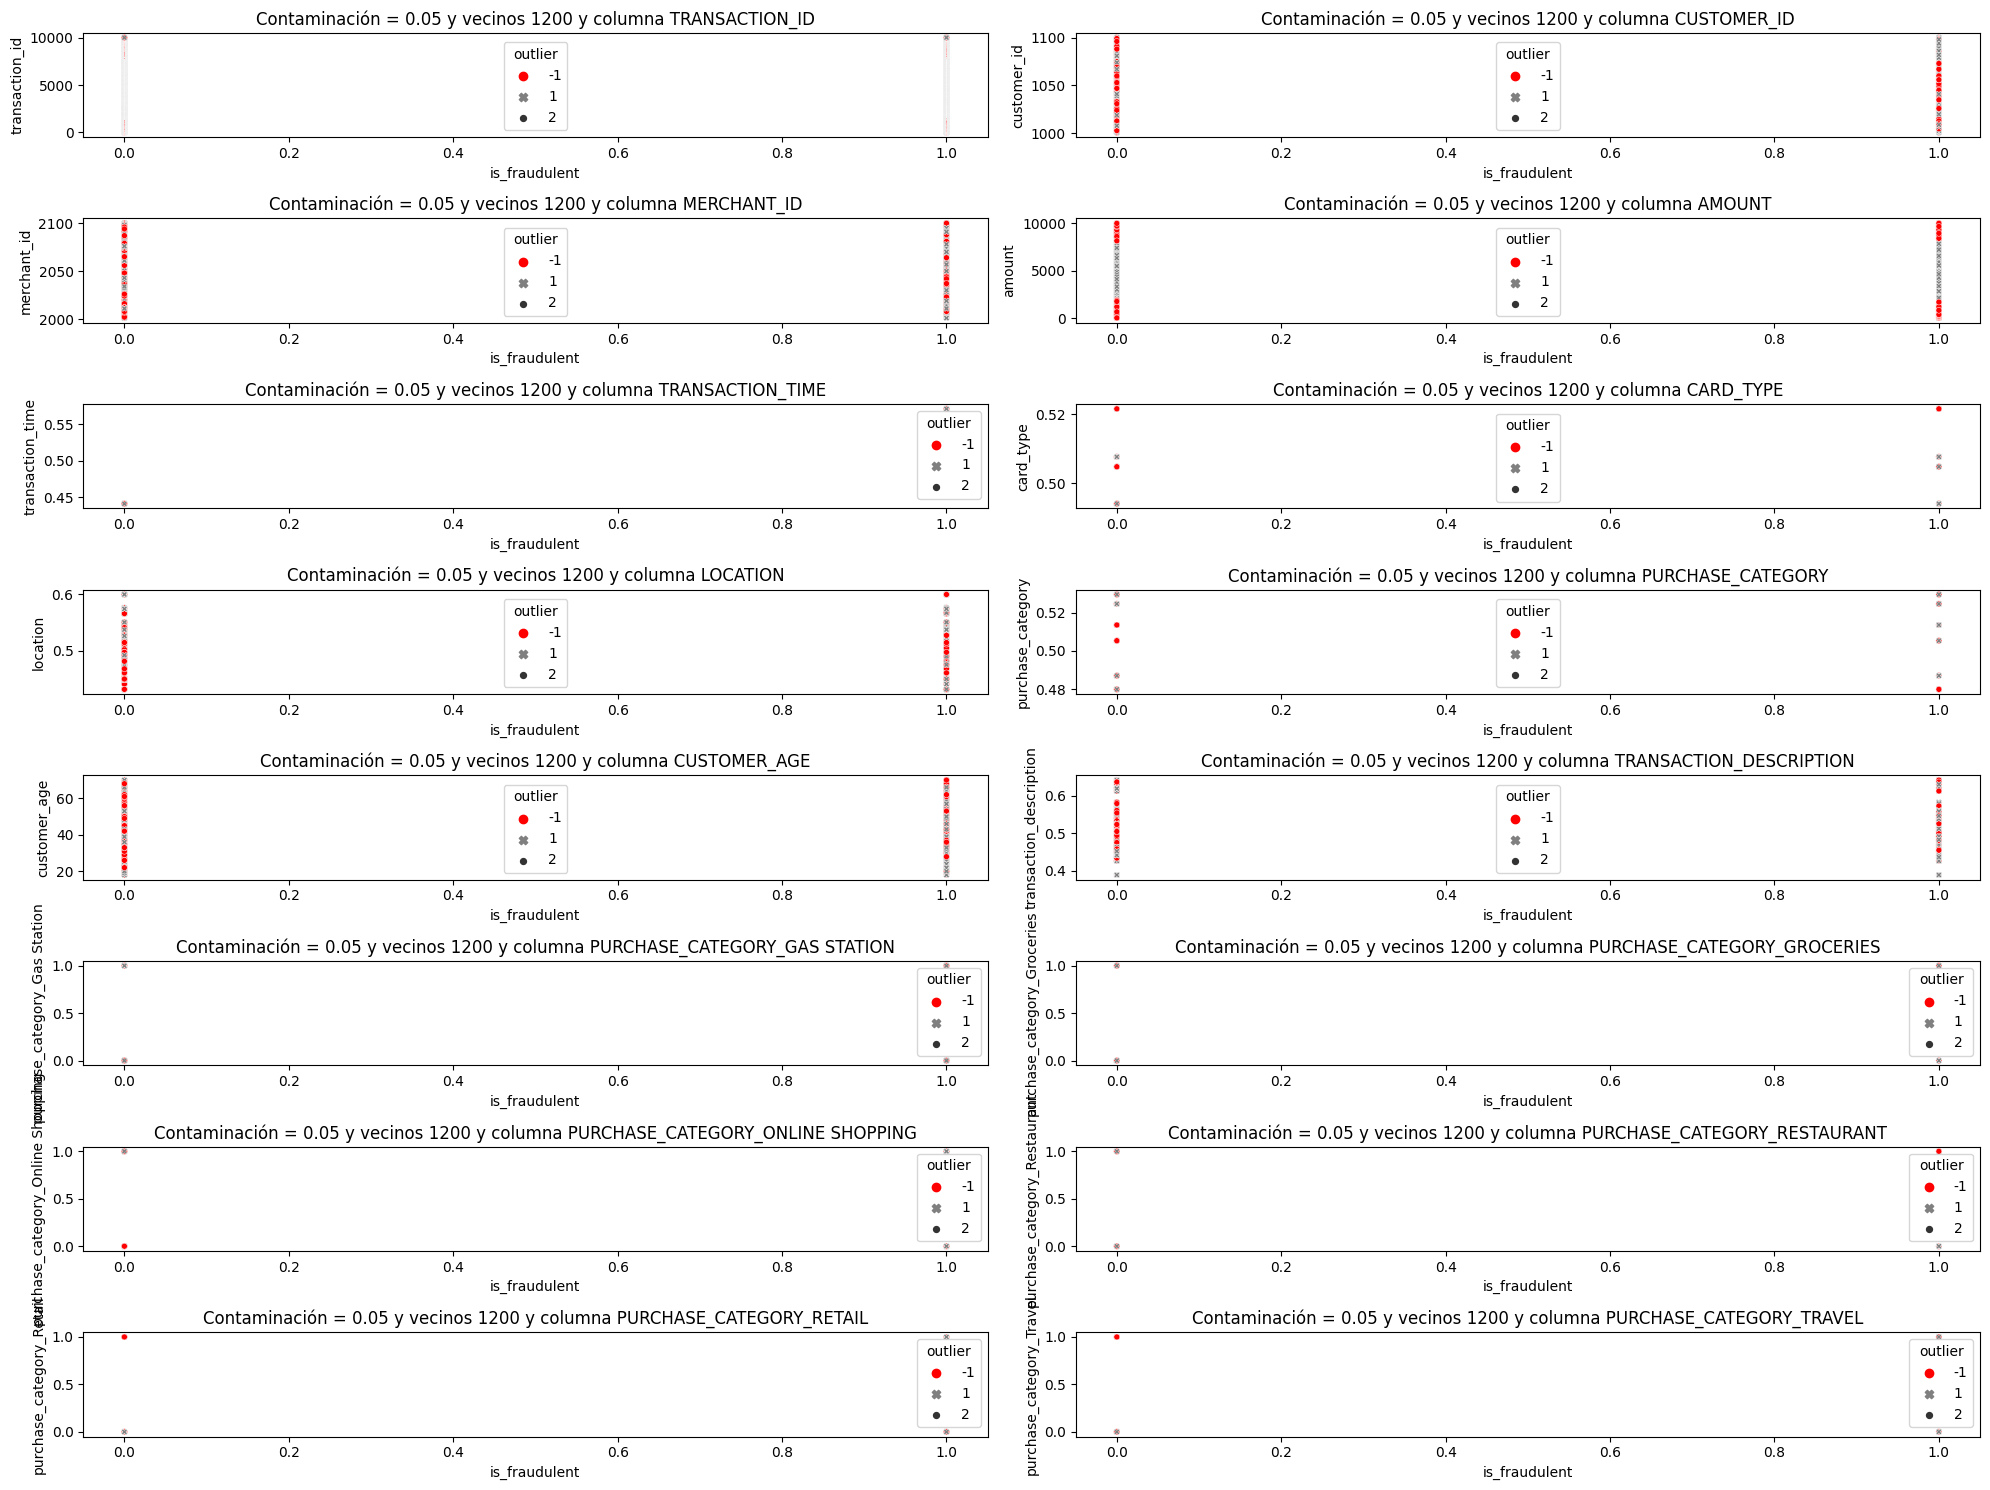

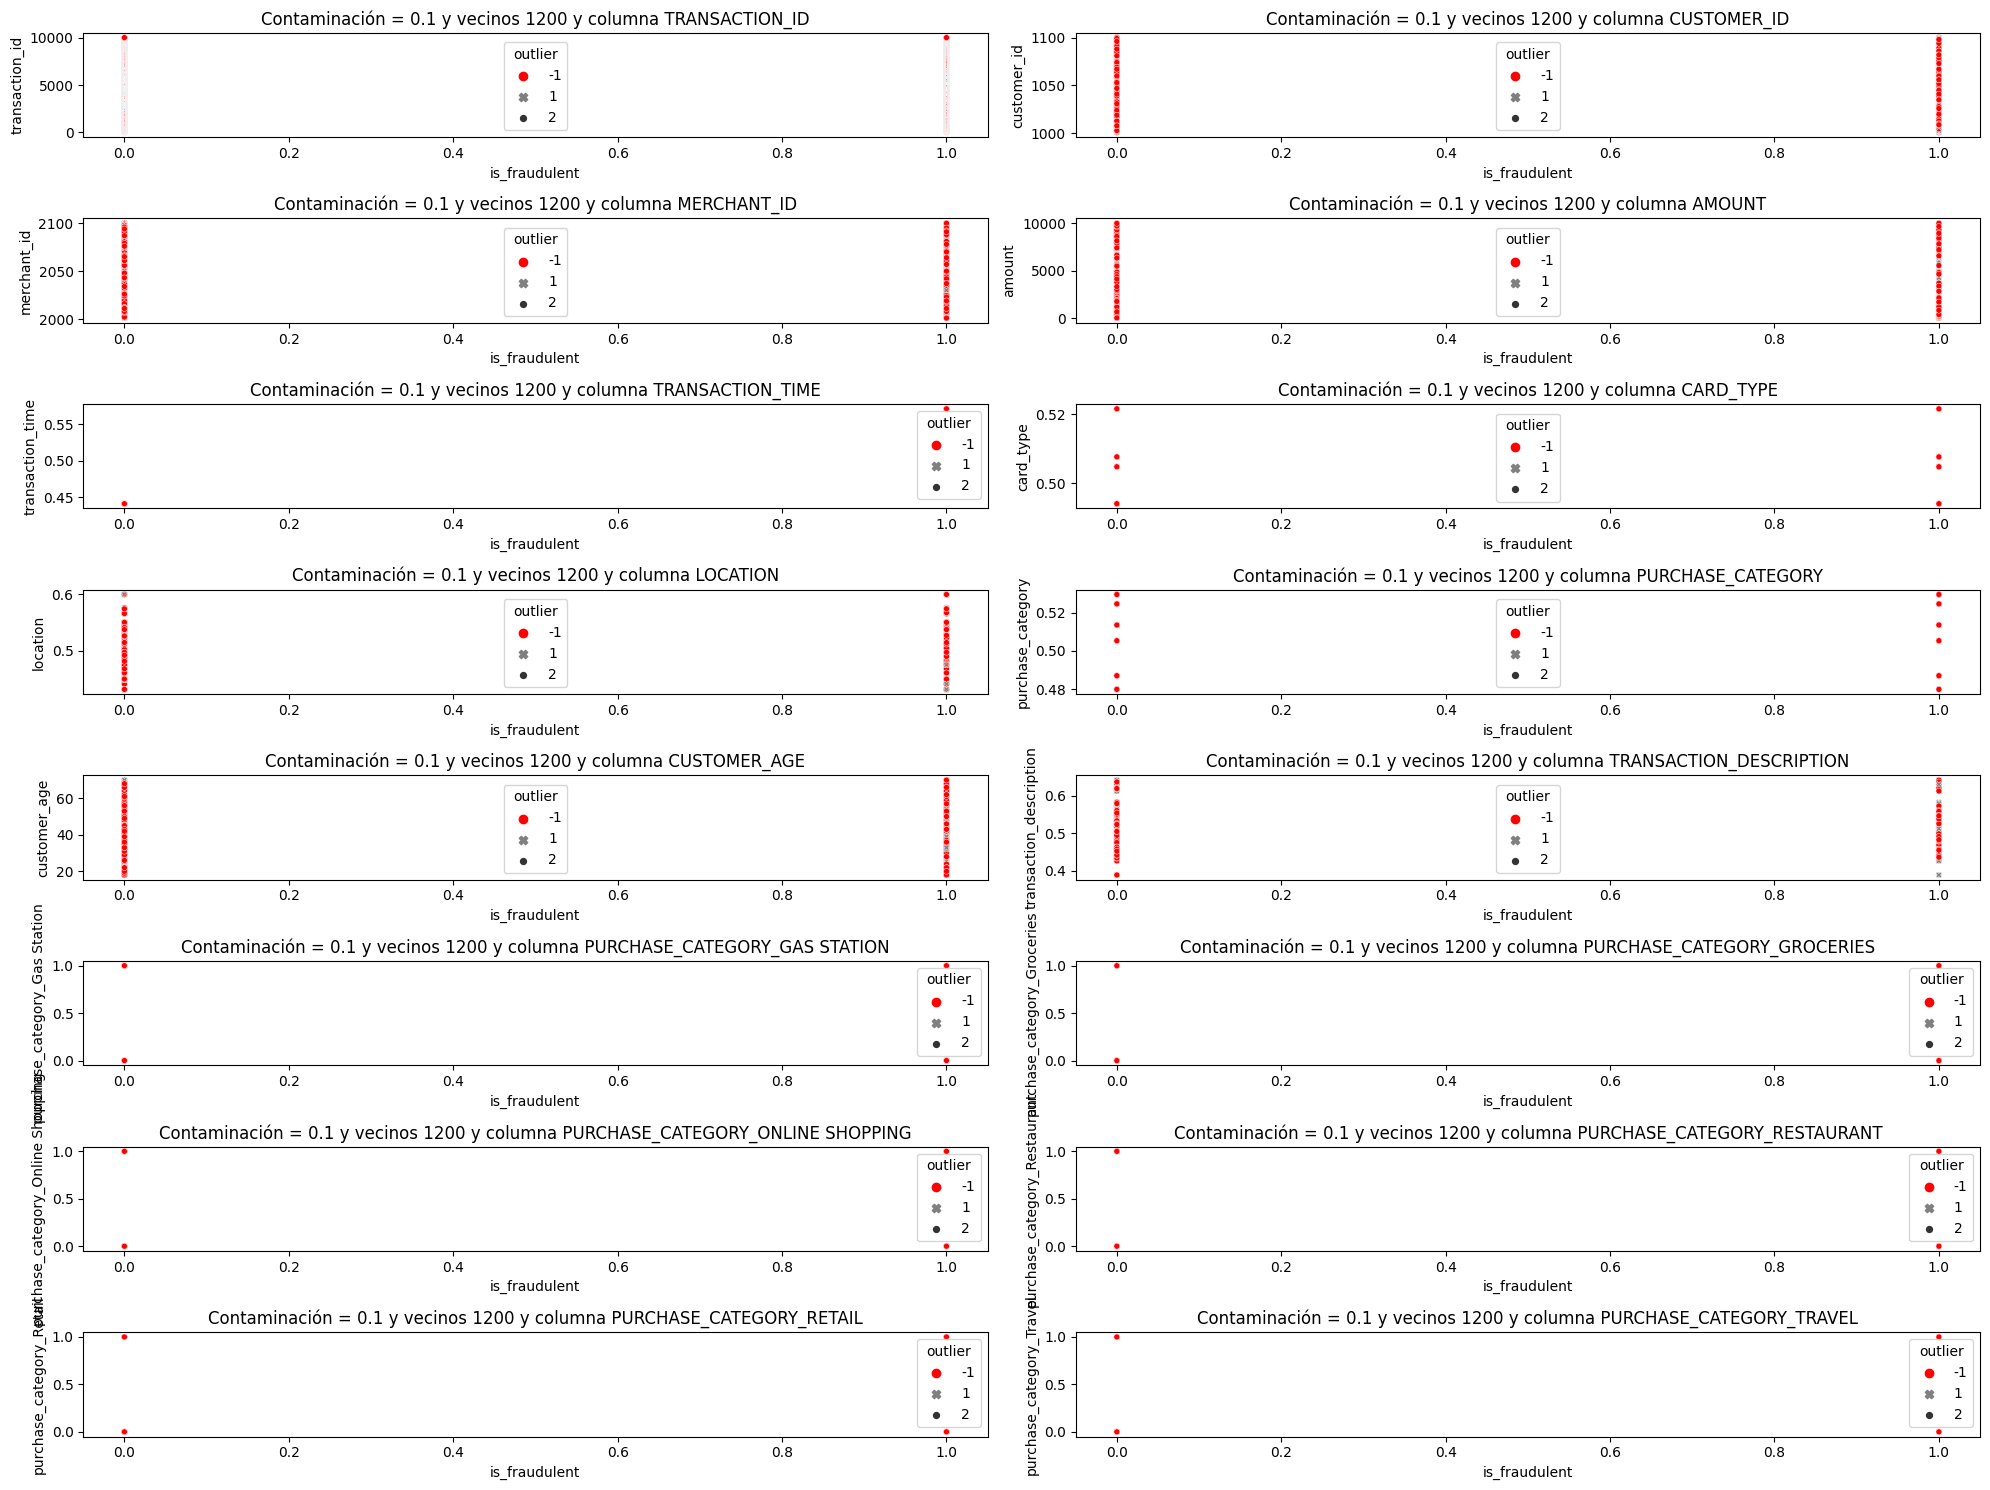

In [18]:
GestorOutliersMultivariados.explorar_outliers_lof("is_fraudulent")

In [19]:
df = GestorOutliersMultivariados.detectar_outliers_if(contaminacion=0.05)

In [20]:
GestorOutliersMultivariados.imputar_outliers(data = df, metodo = "mediana")
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel,outlier
0,1.00,1082,2027,"5,758.59",0.44,0,0.52,0.50,0.52,43,0.52,1.00,0.00,0.00,0.00,0.00,0.00,1
1,2.00,1015,2053,"1,901.56",0.57,1,0.51,0.53,0.49,61,0.54,0.00,0.00,1.00,0.00,0.00,0.00,1
2,"4,977.50",1052,2050,"4,928.59",0.57,1,0.50,0.50,0.51,44,0.51,0.00,0.00,0.00,0.00,0.00,0.00,-1
3,4.00,1095,2037,"7,619.05",0.57,1,0.50,0.60,0.51,59,0.53,0.00,0.00,0.00,0.00,0.00,1.00,1
4,5.00,1036,2083,"1,890.10",0.57,1,0.52,0.50,0.51,36,0.52,0.00,0.00,0.00,0.00,1.00,0.00,1


In [21]:
df.drop("outlier", inplace=True, axis=1)
df.drop("transaction_time", inplace=True, axis=1)

## Estandarización

In [22]:
s1.standar_datos(df, df.select_dtypes(include = np.number).columns)

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel,transaction_id_robust,customer_id_robust,merchant_id_robust,amount_robust,is_fraudulent_robust,card_type_robust,location_robust,purchase_category_robust,customer_age_robust,transaction_description_robust,purchase_category_Gas Station_robust,purchase_category_Groceries_robust,purchase_category_Online Shopping_robust,purchase_category_Restaurant_robust,purchase_category_Retail_robust,purchase_category_Travel_robust,transaction_id_min_max,customer_id_min_max,merchant_id_min_max,amount_min_max,is_fraudulent_min_max,card_type_min_max,location_min_max,purchase_category_min_max,customer_age_min_max,transaction_description_min_max,purchase_category_Gas Station_min_max,purchase_category_Groceries_min_max,purchase_category_Online Shopping_min_max,purchase_category_Restaurant_min_max,purchase_category_Retail_min_max,purchase_category_Travel_min_max,transaction_id_norm,customer_id_norm,merchant_id_norm,amount_norm,is_fraudulent_norm,card_type_norm,location_norm,purchase_category_norm,customer_age_norm,transaction_description_norm,purchase_category_Gas Station_norm,purchase_category_Groceries_norm,purchase_category_Online Shopping_norm,purchase_category_Restaurant_norm,purchase_category_Retail_norm,purchase_category_Travel_norm,transaction_id_estandar,customer_id_estandar,merchant_id_estandar,amount_estandar,is_fraudulent_estandar,card_type_estandar,location_estandar,purchase_category_estandar,customer_age_estandar,transaction_description_estandar,purchase_category_Gas Station_estandar,purchase_category_Groceries_estandar,purchase_category_Online Shopping_estandar,purchase_category_Restaurant_estandar,purchase_category_Retail_estandar,purchase_category_Travel_estandar
0,1.00,1082,2027,"5,758.59",0,0.52,0.50,0.52,43,0.52,1.00,0.00,0.00,0.00,0.00,0.00,-1.07,0.65,-0.49,0.18,-1.00,5.85,-0.11,0.29,-0.04,0.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.82,0.26,0.58,0.00,1.00,0.39,0.90,0.48,0.51,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.93,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.80,1.10,-0.84,0.29,-1.06,1.62,-0.24,0.97,-0.07,0.29,2.29,-0.44,-0.43,-0.42,-0.44,-0.44
1,2.00,1015,2053,"1,901.56",1,0.51,0.53,0.49,61,0.54,0.00,0.00,1.00,0.00,0.00,0.00,-1.07,-0.80,0.06,-0.65,0.00,1.00,0.57,-0.71,0.71,0.58,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.14,0.53,0.19,1.00,0.49,0.58,0.14,0.83,0.58,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.34,0.69,0.64,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.80,-1.31,0.10,-1.09,0.94,0.11,0.65,-1.15,1.15,0.72,-0.44,-0.44,2.34,-0.42,-0.44,-0.44
2,"4,977.50",1052,2050,"4,928.59",1,0.50,0.50,0.51,44,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.52,0.49,0.49,1.00,0.39,0.42,0.68,0.50,0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.14,0.28,0.67,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.02,-0.01,-0.00,0.94,-0.20,-0.09,0.35,-0.00,-0.00,-0.44,-0.44,-0.43,-0.42,-0.44,-0.44
3,4.00,1095,2037,"7,619.05",1,0.50,0.60,0.51,59,0.53,0.00,0.00,0.00,0.00,0.00,1.00,-1.07,0.93,-0.28,0.57,0.00,0.00,2.08,-0.22,0.62,0.38,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.95,0.36,0.76,1.00,0.39,1.00,0.51,0.79,0.54,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.14,0.26,0.96,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.79,1.57,-0.48,0.96,0.94,-0.20,2.64,-0.12,1.02,0.47,-0.44,-0.44,-0.43,-0.42,-0.44,2.26
4,5.00,1036,2083,"1,890.10",1,0.52,0.50,0.51,36,0.52,0.00,0.00,0.00,0.00,1.00,0.00,-1.07,-0.35,0.70,-0.65,0.00,5.85,-0.11,0.00,-0.33,0.34,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.35,0.83,0.19,1.00,1.00,0.39,0.68,0.35,0.53,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.35,0.69,0.63,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.79,-0.55

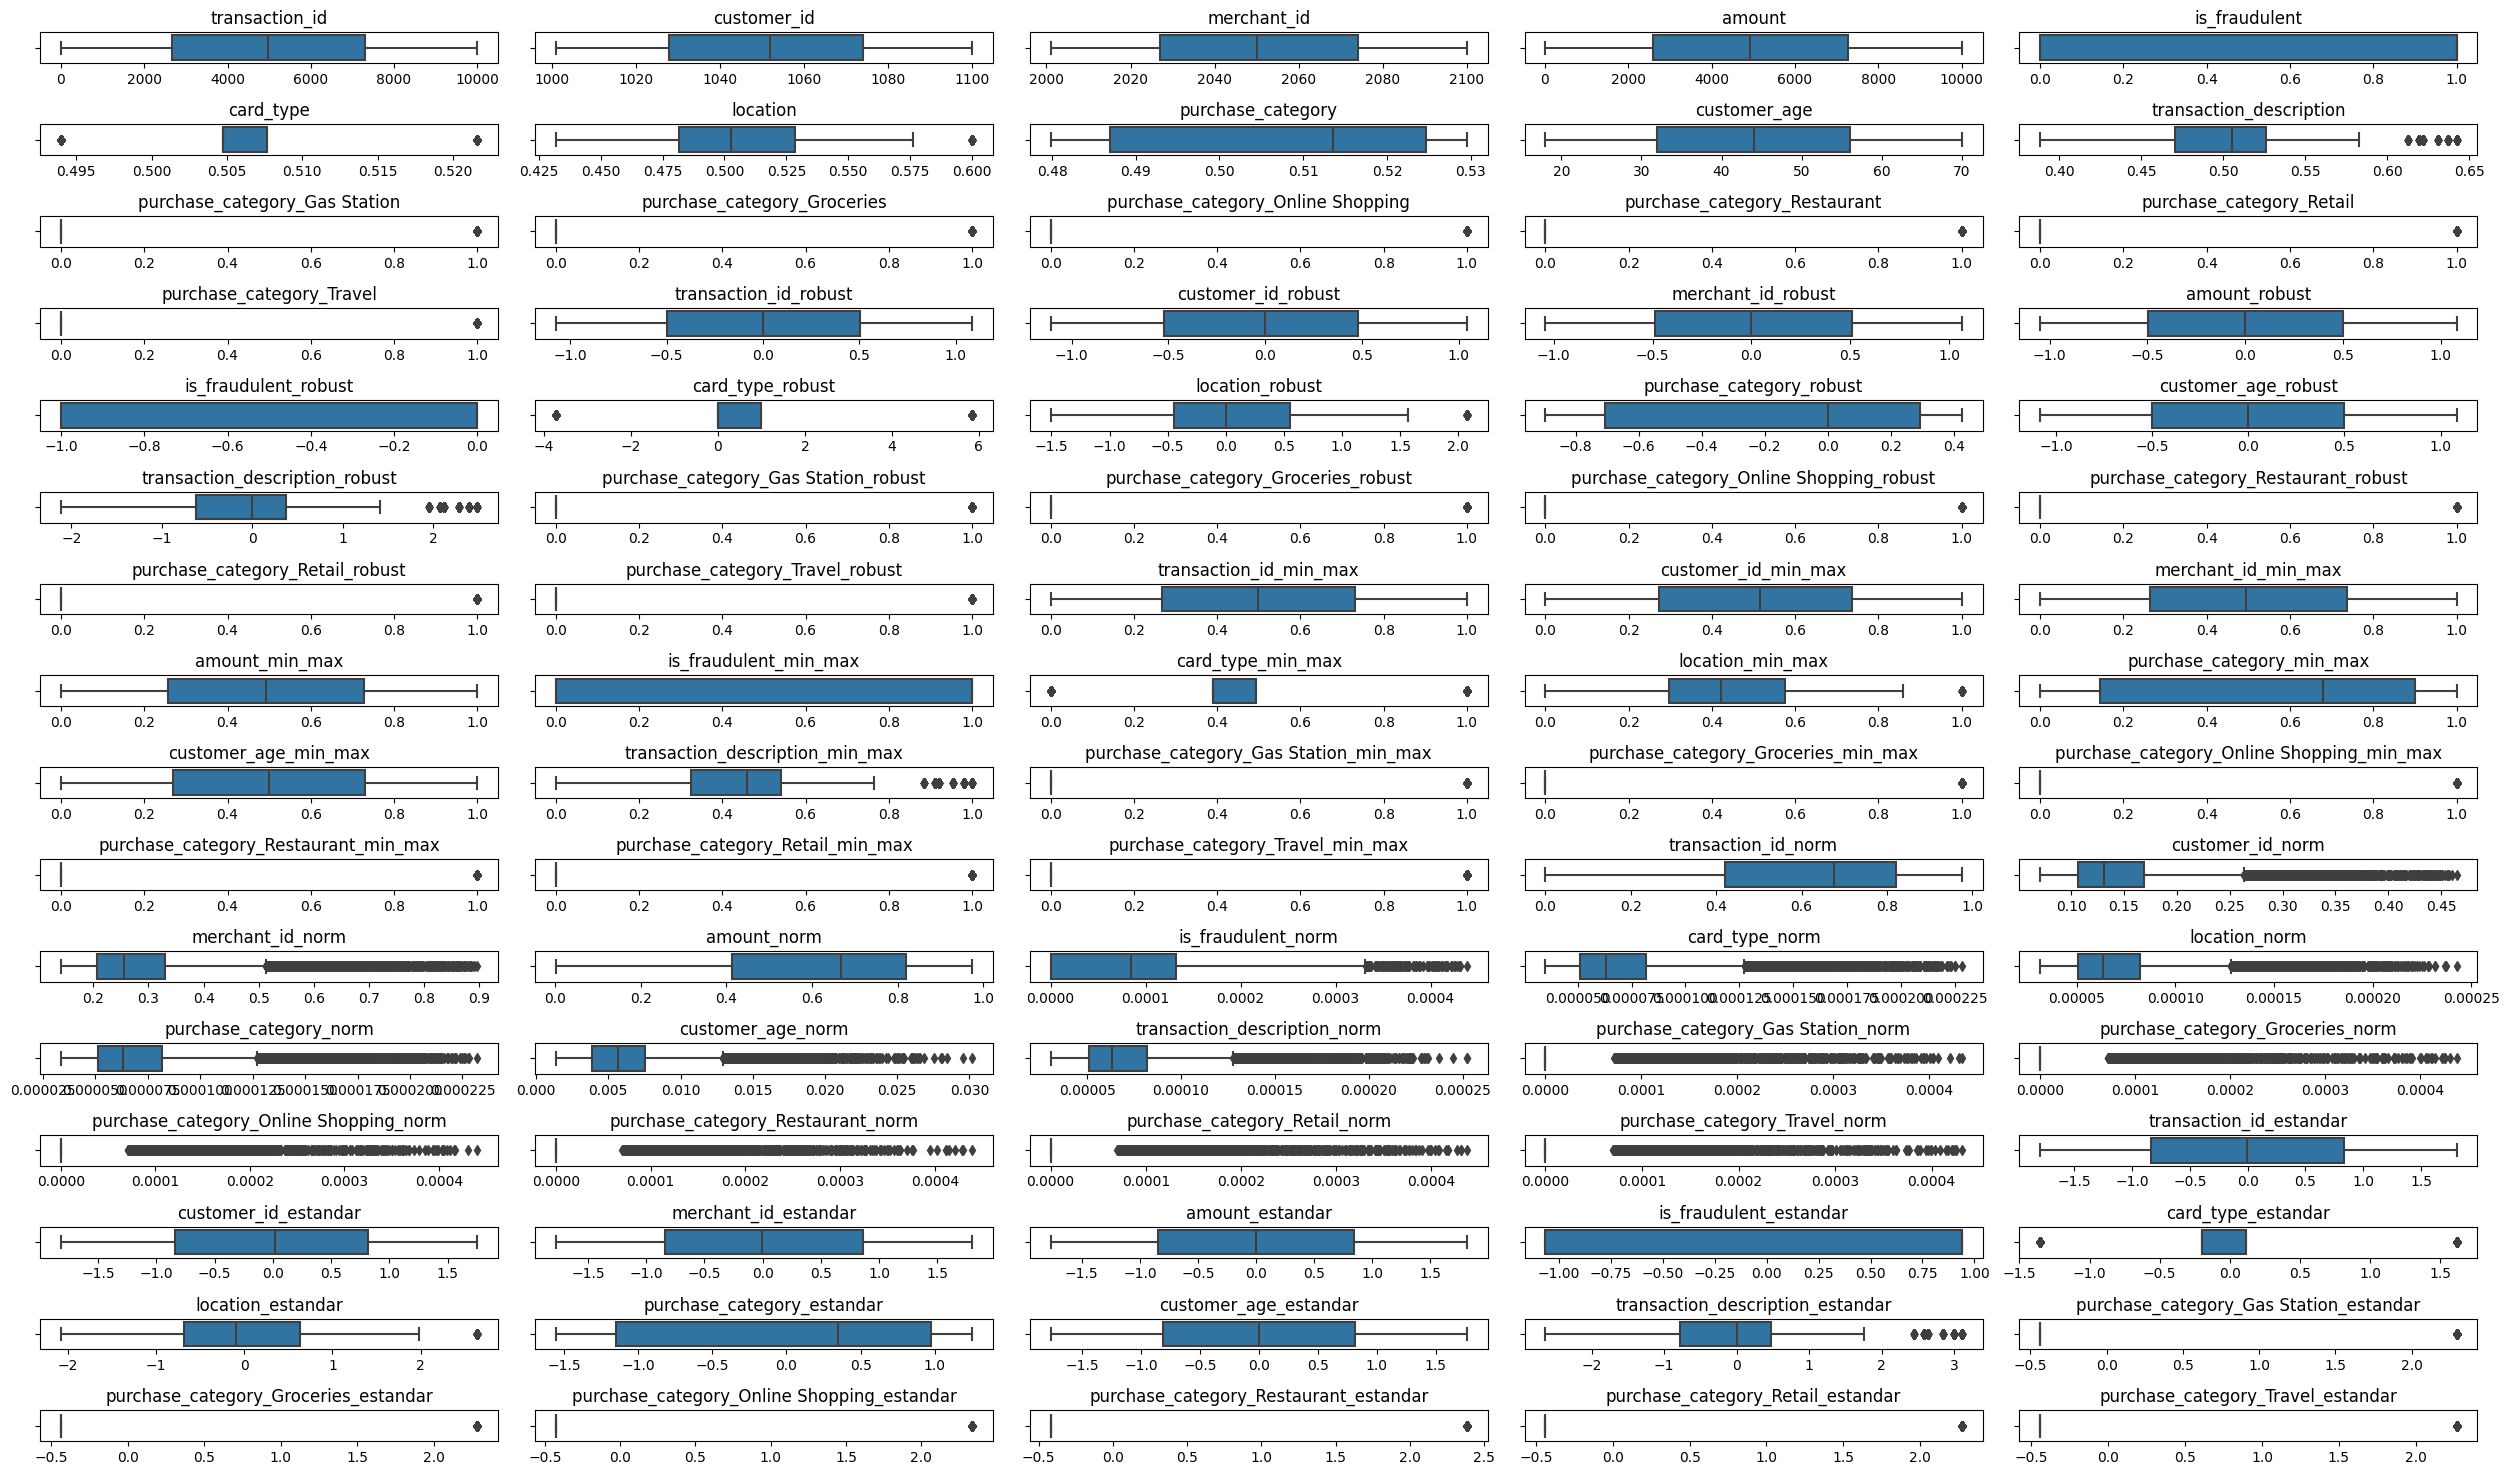

In [23]:
s1.visualizar_tablas(df, df.select_dtypes(include = np.number).columns)

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,"10,000.00","4,984.86","2,775.16",1.00,"2,669.75","4,977.50","7,300.25","10,000.00"
customer_id,"10,000.00","1,051.37",27.73,"1,001.00","1,028.00","1,052.00","1,074.00","1,100.00"
merchant_id,"10,000.00","2,050.20",27.70,"2,001.00","2,027.00","2,050.00","2,074.00","2,100.00"
amount,"10,000.00","4,941.72","2,788.54",10.61,"2,589.66","4,928.59","7,281.97","9,999.75"
is_fraudulent,"10,000.00",0.53,0.50,0.00,0.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...
purchase_category_Groceries_estandar,"10,000.00",0.00,1.00,-0.44,-0.44,-0.44,-0.44,2.29
purchase_category_Online Shopping_estandar,"10,000.00",-0.00,1.00,-0.43,-0.43,-0.43,-0.43,2.34
purchase_category_Restaurant_estandar,"10,000.00",0.00,1.00,-0.42,-0.42,-0.42,-0.42,2.38
purchase_category_Retail_estandar,"10,000.00",-0.00,1.00,-0.44,-0.44,-0.44,-0.44,2.27


In [25]:
df.columns

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'is_fraudulent', 'card_type', 'location', 'purchase_category',
       'customer_age', 'transaction_description',
       'purchase_category_Gas Station', 'purchase_category_Groceries',
       'purchase_category_Online Shopping', 'purchase_category_Restaurant',
       'purchase_category_Retail', 'purchase_category_Travel',
       'transaction_id_robust', 'customer_id_robust', 'merchant_id_robust',
       'amount_robust', 'is_fraudulent_robust', 'card_type_robust',
       'location_robust', 'purchase_category_robust', 'customer_age_robust',
       'transaction_description_robust',
       'purchase_category_Gas Station_robust',
       'purchase_category_Groceries_robust',
       'purchase_category_Online Shopping_robust',
       'purchase_category_Restaurant_robust',
       'purchase_category_Retail_robust', 'purchase_category_Travel_robust',
       'transaction_id_min_max', 'customer_id_min_max', 'merchant_id_min_max'

In [27]:
columnas_a_eliminar = ['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'card_type', 'location', 'purchase_category',
       'customer_age', 'transaction_description', 'transaction_id_min_max',
       'customer_id_min_max', 'merchant_id_min_max', 'amount_min_max',
       'is_fraudulent_min_max', 'card_type_min_max', 'location_min_max',
       'purchase_category_min_max', 'customer_age_min_max',
       'transaction_description_min_max', 'transaction_id_norm',
       'customer_id_norm', 'merchant_id_norm', 'amount_norm',
       'is_fraudulent_norm', 'card_type_norm', 'location_norm',
       'purchase_category_norm', 'customer_age_norm',
       'transaction_description_norm', 'transaction_id_estandar',
       'customer_id_estandar', 'merchant_id_estandar', 'amount_estandar',
       'is_fraudulent_estandar', 'card_type_estandar', 'location_estandar',
       'purchase_category_estandar', 'customer_age_estandar',
       'transaction_description_estandar', 'is_fraudulent_robust',
       
       'purchase_category_Gas Station_robust',
       'purchase_category_Groceries_robust',
       'purchase_category_Online Shopping_robust',
       
       'purchase_category_Restaurant_robust',
       'purchase_category_Retail_robust', 'purchase_category_Travel_robust',
       'purchase_category_Gas Station_min_max',
       'purchase_category_Groceries_min_max',
       'purchase_category_Online Shopping_min_max',
       'purchase_category_Restaurant_min_max',
       'purchase_category_Retail_min_max', 'purchase_category_Travel_min_max',
       'purchase_category_Gas Station_norm',
       'purchase_category_Groceries_norm',
       'purchase_category_Online Shopping_norm',
       'purchase_category_Restaurant_norm', 'purchase_category_Retail_norm',
       'purchase_category_Travel_norm',
       'purchase_category_Gas Station_estandar',
       'purchase_category_Groceries_estandar',
       'purchase_category_Online Shopping_estandar',
       'purchase_category_Restaurant_estandar',
       'purchase_category_Retail_estandar',
       'purchase_category_Travel_estandar']
df.drop(columnas_a_eliminar, inplace=True, axis=1)

In [28]:
df.columns

Index(['is_fraudulent', 'purchase_category_Gas Station',
       'purchase_category_Groceries', 'purchase_category_Online Shopping',
       'purchase_category_Restaurant', 'purchase_category_Retail',
       'purchase_category_Travel', 'transaction_id_robust',
       'customer_id_robust', 'merchant_id_robust', 'amount_robust',
       'card_type_robust', 'location_robust', 'purchase_category_robust',
       'customer_age_robust', 'transaction_description_robust'],
      dtype='object')

In [29]:
df.to_pickle("datos/financial_data_prepocesamiento.pkl")